In [1]:
%load_ext autoreload
%autoreload 2

from statsmodels.base.model import GenericLikelihoodModel

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
import sys

from scipy.interpolate import make_interp_spline, BSpline
from scipy.stats import multivariate_normal

sys.path.append("../")
import vuong_tests8 as vuong_tests_fast

In [2]:
class JointNormal1(GenericLikelihoodModel):
    
    def loglikeobs(self, params):
        data = np.concatenate([[self.endog],self.exog.transpose()],axis=0)
        mult_rv = stats.multivariate_normal([params[0], 0.0], [[1,0],[0,1]])
        return mult_rv.logpdf(data.transpose())
    
    
class JointNormal2(GenericLikelihoodModel):
    
    def loglikeobs(self, params):
        data = np.concatenate([[self.endog],self.exog.transpose()],axis=0)
        mult_rv = stats.multivariate_normal([0.0, params[0]], [[1,0],[0,1]])
        return mult_rv.logpdf(data.transpose())


def setup_shi(yn,xn):
    # model 1 grad, etc.
    nobs = yn.shape[0]
    model1_param = np.array([yn.mean()])
    model2_param = np.array([xn.mean()])
    
    model1_deriv = JointNormal1(yn,xn)
    ll1 = model1_deriv.loglikeobs(model1_param)
    grad1 =  model1_deriv.score_obs(model1_param).reshape( (nobs,1) )
    hess1 = model1_deriv.hessian(model1_param)
    
    
    model2_deriv = JointNormal2(yn,xn)
    ll2 = model2_deriv.loglikeobs(model2_param)
    grad2 =  model2_deriv.score_obs(model2_param).reshape( (nobs,1) )  
    hess2 = model2_deriv.hessian(model2_param)
    
    return ll1,grad1,hess1,model1_param,ll2,grad2,hess2,model2_param

def gen_data(beta= 1.5, nobs=1000):
    cov = [[25, 0], [0, 1]]
    data = np.random.multivariate_normal([beta,beta], [[25,0],[0,1]],  nobs)
    return data[:,0],data[:,1],nobs

yn,xn,nobs = gen_data()
ll1,grad1,hess1,params1,ll2,grad2,hess2,params2 = setup_shi(yn,xn)
print(grad1.shape,hess1.shape)
#NOTE! Weird size distortions with shi's test when theta = .5....

(1000, 1) (1, 1)


In [3]:
nsims= 700
trials =1000
skip_boot=False
skip_shi=False
refinement_test=True
linspace=40
smoothing =5
adapt_c= True


calc_c =lambda nobs: (.1*nobs**(-1/4)/np.sqrt(nobs), (nobs+10)**(-1/3))
print(calc_c(200))

(0.0018803015465431968, 0.16823908657399744)


# Size stuff

In [4]:
betas = np.linspace(0,3,linspace)
nobs = 500
c1,c2 = calc_c(nobs)

results = []

for beta in betas:
    setup_shi_ex  = lambda yn,xn: setup_shi(yn,xn,num_params=num_params)
    gen_data_ex = lambda : gen_data(nobs=nobs, beta =beta)
    mc_out = vuong_tests_fast.monte_carlo(nsims,gen_data_ex,setup_shi,trials=trials,
                                          skip_boot=skip_boot,skip_shi=skip_shi,refinement_test=refinement_test,c1=c1,c2=c2)
    reg,twostep, refine_test, boot1,boot2,boot3,shi, llr,std, omega = mc_out
    results.append([reg,twostep,refine_test,shi,boot1,boot2,boot3])
    print(beta,boot3)

0.3041013158217678 0.14535994510827965 4.392656644252166
-4.338933947562583 0.14535994510827965 -0.25037861913218507
---
1.446722458497315 -0.2425793371718222 5.413777833575225
-5.390063799142949 -0.2425793371718222 -1.4230084240650376
---
4.472975792280713 -0.967001303955172 8.36346444727901
-8.350457170256021 -0.967001303955172 -4.459968515257725
---
-0.8699916850293395 0.9334451136506821 3.131663182675954
-3.1969251474840368 0.9334451136506821 0.8047297202212567
---
2.4533164235877964 -0.7274929537559292 6.523932766569844
-6.670869839287854 -0.7274929537559292 -2.6002534963058053
---
17.73916268473346 -3.6184584030844285 21.556828278386355
-21.690619837711 -3.6184584030844285 -17.872954244058107
---
5.675276205547285 -1.2416679608016699 9.706057360024516
-9.725532070007846 -1.2416679608016699 -5.694750915530616
---
-0.7598912980593084 0.7943566350258372 3.0308491868692515
-3.149749535556848 0.7943566350258372 0.6409909493717122
---
-1.135343464301816 1.2274677989949565 2.86035192137

7.045996535014889 -2.571825026349936 10.87253021176284
-10.938022422673034 -2.571825026349936 -7.111488745925082
---
-0.8191178469950005 0.9309015935881141 3.1673449433608245
-3.1184751593912248 0.9309015935881141 0.8679876309646003
---
-0.6852236275254888 0.7314107944029795 3.3179135737143213
-3.159525976735868 0.7314107944029795 0.843611224503942
---
2.381454404772736 -1.1340446888583027 6.203605626978823
-6.227962146250826 -1.1340446888583027 -2.4058109240447387
---
-0.1064071422005712 0.1709765098613863 3.913666649251589
-3.9000699546714177 0.1709765098613863 0.12000383678074245
---
0.8740421833443942 -0.5795134825196218 4.474374211684402
-4.3115432361678225 -0.5795134825196218 -0.7112112078278153
---
1.013499664056507 -0.5376552815137186 4.967366462521363
-4.908955844286281 -0.5376552815137186 -0.9550890458214248
---
-0.4050873617530298 0.2612494800859381 3.4699882288252786
-3.601187296310311 0.2612494800859381 0.2738882942679973
---
10.008498539392555 -2.6020023694388272 13.67948

-0.49492101101576913 0.06599016482422353 3.284498272529442
-3.4750404577359806 0.06599016482422353 0.3043788258092302
---
-0.3798981281172566 0.06519179891519848 3.506101327082283
-3.194212834467423 0.06519179891519848 0.6917866207321164
---
-1.1894194097534228 0.8928967001210013 2.8209036412060753
-3.0436942932130235 0.8928967001210013 0.9666287577464746
---
0.3076923076923077 [1. 0. 0.]
-0.8805934028147469 0.3528303288386519 3.1494584042186733
-3.001982001475277 0.3528303288386519 1.0280698055581425
---
-1.050882253002924 0.3459175346963286 2.944849695624198
-3.0680519424521315 0.3459175346963286 0.9276800061749906
---
-1.0309553684594561 0.7330242483691353 2.8968066829440033
-2.7158271335305657 0.7330242483691353 1.2119349178728933
---
-0.8900031275671942 0.2757909590075811 2.983128236463638
-3.125320540513616 0.2757909590075811 0.7478108235172165
---
0.10672904885725015 -0.5851715816691483 4.068170266949141
-4.051819954917934 -0.5851715816691483 -0.09037873682604299
---
-0.73984624

-1.0371206581873735 -0.044794643463992354 2.9578792276262798
-3.0632858411534074 -0.044794643463992354 0.9317140446602457
---
-0.08982845280648566 -1.6837443416555422 3.6933513779093152
-3.490094833987648 -1.6837443416555422 0.29308499672815347
---
-1.2409093094482166 0.4911355344110235 2.7406116038928516
-2.9291478725717868 0.4911355344110235 1.0523730407692813
---
-0.30549624624601823 -1.4184011971340857 3.5954455135006693
-3.7159293500893478 -1.4184011971340857 0.18501240965733964
---
-0.6266887009283477 -0.7479211448545963 3.195622854983908
-3.046902970121109 -0.7479211448545963 0.7754085857911469
---
-0.5392515317364789 -0.7715722027714723 3.2974885609833837
-3.162228548154892 -0.7715722027714723 0.6745115445649709
---
-0.9460988084323578 -0.23704434422448667 2.951437057503524
-2.9877475747338833 -0.23704434422448667 0.9097882912019987
---
-1.2163634196090631 0.5025836600274175 2.7289287799524398
-2.8023475136478404 0.5025836600274175 1.1429446859136625
---
-1.1515248778025484 0.5

-0.8819250318356164 -0.7984746223353345 2.8577467707963597
-2.852129200599478 -0.7984746223353345 0.8875426020324984
---
-1.39827961958631 0.6109881061982709 2.577648923227525
-2.7508102013418783 0.6109881061982709 1.2251183414719569
---
-1.5040046290521139 0.9259497547386635 2.582961669747666
-2.6178416860180893 0.9259497547386635 1.4691246127816904
---
-1.0245910257386317 -0.9342088279442116 2.970273048990222
-2.8574499527639747 -0.9342088279442116 1.1374141219648795
---
-1.3643042447952616 0.5866255426209426 2.6489878887013343
-2.78046881661609 0.5866255426209426 1.232823316880506
---
-1.1522171209170378 -0.10504573262678162 2.7861997373776943
-2.9190091719515445 -0.10504573262678162 1.0194076863431878
---
-1.3113832283054234 0.35629379198822575 2.634839419065989
-2.6568598052354857 0.35629379198822575 1.2893628421359267
---
0.6923076923076923 [0.98       0.00142857 0.01857143]
-1.5522666940073782 1.280354682849952 2.5914063557429383
-2.582135134587584 1.280354682849952 1.5615379151

-1.452527037302415 0.16608010888291616 2.5991144726586533
-2.657257865062135 0.16608010888291616 1.3943836448989335
---
-1.4142082149103885 0.557675321558945 2.669725622994148
-2.609511867432925 0.557675321558945 1.4744219704716115
---
-1.3106879006683536 -0.2723639781495779 2.5211723536702593
-2.5038835897438814 -0.2723639781495779 1.3279766645947315
---
-1.3230365016609071 -0.2907926201282968 2.485221719366113
-2.4649236246863944 -0.2907926201282968 1.3433345963406258
---
-1.3378455676984267 -0.8159622582958335 2.6357615111961015
-2.732471952344083 -0.8159622582958335 1.241135126550445
---
-1.3994774452355716 0.5866660993060981 2.5989615065
-2.4436833478985465 0.5866660993060981 1.5547556038370247
---
-1.576051848958643 0.5516316834955067 2.5927839552983643
-2.508651642877154 0.5516316834955067 1.660184161379853
---
-1.172014866963183 -1.5827056500071575 2.817835041085912
-2.790272905360465 -1.5827056500071575 1.1995770026886303
---
-1.256777009282012 -0.9867750677825609 2.7189112701

-1.3961081816106382 -1.3107514692066022 2.685843019490799
-2.666346914222315 -1.3107514692066022 1.4156042868791219
---
-1.5082393572386787 -1.147815852361406 2.3756397354929066
-2.6987241786804517 -1.147815852361406 1.1851549140511335
---
-1.3979067392093436 0.18008366020363095 2.562361028785516
-2.471870115862577 0.18008366020363095 1.488397652132282
---
-1.7199029336286213 0.745752832275238 2.360562777173023
-2.6923785257494575 0.745752832275238 1.388087185052187
---
-1.5430550476778941 -0.3263299151948359 2.380955458368358
-2.6142546603769587 -0.3263299151948359 1.309755845669293
---
-1.4565272074939473 0.8137638805378642 2.381997849365537
-2.3546179604611988 0.8137638805378642 1.4839070963982852
---
-1.487292599449039 1.1733667587031382 2.2474920863502406
-2.3019159279613532 1.1733667587031382 1.432868757837926
---
-1.3616173898338173 -0.7784913265720391 2.5000883110665786
-2.477158825799674 -0.7784913265720391 1.384546875100722
---
-1.3871752502953867 -0.224008636846363 2.5380668

-1.5456070088392586 0.5269488871986695 2.463024708623263
-2.3360233064755382 0.5269488871986695 1.6726084109869839
---
-1.4278074108690408 -1.1165792522490516 2.5427406443695575
-2.466298099463081 -1.1165792522490516 1.5042499557755171
---
-1.6848014574958716 0.4859500231515737 2.411438883041727
-2.490127836797833 0.4859500231515737 1.6061125037397654
---
-1.4114855730864175 -0.4418516096887596 2.279148891273699
-2.356316881737232 -0.4418516096887596 1.3343175826228846
---
-1.417830885514327 0.3106498386937828 2.356683175983441
-2.1680052947762065 0.3106498386937828 1.6065087667215616
---
-1.4138080917071 -0.12460764643791161 2.3149473128209967
-2.280353890929066 -0.12460764643791161 1.4484015135990311
---
-1.4564807897662806 -0.03513427686150818 2.30018612696557
-2.3279898372376984 -0.03513427686150818 1.428677079494152
---
-1.532829500863226 -1.2102791370125168 2.5588631779994597
-2.5672077188509044 -1.2102791370125168 1.5244849600117818
---
-1.6735472966449867 1.0172622225734833 2.1

-1.6366329115501053 -1.3532212935027097 2.350238338478495
-2.5169129869402944 -1.3532212935027097 1.4699582630883063
---
-1.5403884376056955 -0.7009542114185827 2.4911087216494656
-2.459140756251826 -0.7009542114185827 1.5723564030033352
---
-1.6465655302000815 -0.12038909632400131 2.2589424851088338
-2.370118584071012 -0.12038909632400131 1.5353894312379028
---
-1.5259577205702535 -0.7822644502436467 2.3832361458885134
-2.3592826258050987 -0.7822644502436467 1.5499112406536681
---
-1.5378821698920304 0.0524913529289101 2.262006290445447
-2.2559310027771393 0.0524913529289101 1.543957457560338
---
-1.5275410007732289 1.141298426526071 2.283686482708218
-2.1432307580881313 1.141298426526071 1.667996725393316
---
-1.3671556294542238 -1.5627049532327772 2.4285417301369208
-2.3764916346766527 -1.5627049532327772 1.4192057249144918
---
-1.5009092270249496 -0.0042704558595445434 2.394056790151665
-2.2198619284225822 -0.0042704558595445434 1.675104088754033
---
-1.5254265181730033 0.720680143

-1.5912827024708285 -0.879706361920496 2.413298632218237
-2.3675330469688767 -0.879706361920496 1.6370482877201893
---
-1.694654305725478 0.27641916177434267 2.142001735763917
-2.3555868562014957 0.27641916177434267 1.4810691852878994
---
-1.6077418307116926 1.6977345572496865 2.295208365921295
-2.154352849594653 1.6977345572496865 1.7485973470383345
---
1.6153846153846154 [0.96857143 0.00714286 0.02428571]
-1.6899605435125815 -0.7059016077354865 2.446609492940849
-2.4330079538268654 -0.7059016077354865 1.7035620826265654
---
-1.6341823065429273 1.0756027678603228 2.2007673057718304
-2.230928732314178 1.0756027678603228 1.6040208800005795
---
-1.6398134373260167 1.2892173444902428 2.303627364147118
-2.2444337883935477 1.2892173444902428 1.6990070130795867
---
-1.5815221617079938 -0.5857388686805612 2.2199121436149856
-2.3211717905314377 -0.5857388686805612 1.4802625147915418
---
-1.5809403405822908 -0.7649165630752586 2.260527936820172
-2.2775972883977964 -0.7649165630752586 1.56387098

-1.6468102959891644 -0.8140498557142836 2.302372582313802
-2.276126576566409 -0.8140498557142836 1.6730563017365576
---
-1.651886654382243 0.6971134451632874 2.250226834921193
-2.199431536508212 0.6971134451632874 1.7026819527952244
---
-1.5291640524758077 -0.08686070172213767 2.2456381424519156
-2.1730243782482246 -0.08686070172213767 1.6017778166794991
---
-1.7021711316602328 -0.30290367354683834 2.3823830728516553
-2.3708944800887926 -0.30290367354683834 1.7136597244230956
---
-1.6388157348042276 0.9402293659833663 2.2941346070860114
-2.17276468427724 0.9402293659833663 1.7601856576129988
---
-1.7379844478134812 -0.12438637154131409 2.333661194878346
-2.3251928799011727 -0.12438637154131409 1.7464527627906548
---
-1.6773665977798182 1.1332499862710792 2.1334082675919728
-2.2322065099579675 1.1332499862710792 1.5785683554138235
---
-1.753650665922471 0.37626087514047757 2.3602182222701997
-2.341393740186427 0.37626087514047757 1.7724751480062442
---
-1.680354325798095 1.0532421369484

-1.680613838441705 1.2572806415535263 2.1906267768527634
-2.172553154435325 1.2572806415535263 1.6986874608591431
---
-1.690087671360705 -1.2201809350509123 2.151203945091182
-2.3517040079711133 -1.2201809350509123 1.4895876084807738
---
-1.648002470140064 -0.5768057306693484 2.266048791024237
-2.2250266171871877 -0.5768057306693484 1.6890246439771133
---
-1.8013599111855096 -0.01867016025858898 2.3841336939631272
-2.369918911929942 -0.01867016025858898 1.8155746932186945
---
-1.7836809051495468 1.2503938755346682 2.286177289749732
-2.2939919632569725 1.2503938755346682 1.7758662316423062
---
-1.6758479988658488 -0.9004045270293922 2.096498233376474
-2.302515433690263 -0.9004045270293922 1.4698307985520598
---
-1.6546228753927286 -0.46858444595384424 2.191394217760353
-2.201861456584996 -0.46858444595384424 1.6441556365680858
---
2.0 [0.97285714 0.00571429 0.02142857]
-1.598425866476335 0.48073418733923756 2.1706296381914614
-2.098037882275498 0.48073418733923756 1.6710176223922986
---

-1.7644951375517526 0.7689101364921904 2.261399088724949
-2.202216820049755 0.7689101364921904 1.823677406226946
---
-1.8012620328490803 1.4280483274887743 2.2771997503308157
-2.2509451687593067 1.4280483274887743 1.827516614420589
---
-1.6633659827313576 -0.9839556124271782 2.1752543283981107
-2.18366726235856 -0.9839556124271782 1.6549530487709079
---
-1.6859691401190562 0.08973535593015745 2.1952478874855488
-2.1826223778871556 0.08973535593015745 1.6985946497174493
---
-1.9394459286524037 0.11021292750527696 2.2798341354090326
-2.435757620051147 0.11021292750527696 1.7835224440102897
---
-1.6135793149939213 0.6993348658065404 2.1371897754118123
-2.116939772069209 0.6993348658065404 1.633829318336525
---
-1.8548133865097585 0.27377377445581114 2.3983835122433765
-2.335491269363527 0.27377377445581114 1.9177056293896078
---
-1.7716968670598903 -1.0425922684144857 2.160002768076499
-2.313199897860045 -1.0425922684144857 1.618499737276344
---
-1.6664919617352478 -2.1860096525955326 2.2

-1.7183377025746556 -0.038639130392390586 2.24855569253529
-2.20927814179652 -0.038639130392390586 1.7576152533134257
---
-1.6992412834809543 0.4978381552586748 2.0242738017020483
-2.12909355666963 0.4978381552586748 1.5944215285133727
---
-1.662545341278081 0.5276615950163905 2.139900992228587
-2.109394896857929 0.5276615950163905 1.6930514366487395
---
-1.6887066811153353 -0.7032600211751061 2.23348243551102
-2.1302113704394436 -0.7032600211751061 1.791977746186912
---
-1.7290914888417215 -0.386604894628156 2.2227300210654377
-2.196687847173182 -0.386604894628156 1.7551336627339769
---
-1.7820534420494818 0.115494665848654 2.090307110709734
-2.233486501138048 0.115494665848654 1.6388740516211677
---
-1.8339907355197362 0.6972045832848226 2.2553539303625647
-2.2826543997270954 0.6972045832848226 1.8066902661552053
---
-1.624722536071927 0.8610347471225418 2.1942384636949166
-2.051582222686474 0.8610347471225418 1.7673787770803697
---
-1.9331939955472661 1.5217735655956441 2.1625894049

-1.6753662040487223 -0.8904529110733589 2.0128105855837903
-2.1139709421265804 -0.8904529110733589 1.5742058475059322
---
-1.7144380334069405 -0.7481869951048306 2.097193316218875
-2.165152317235382 -0.7481869951048306 1.6464790323904335
---
-1.7728452648223811 1.4544468843680636 2.2075872352653714
-2.1299429289723513 1.4544468843680636 1.850489571115401
---
-1.7599640192306623 -0.15817259488674468 2.1881836512126047
-2.173407699631417 -0.15817259488674468 1.77473997081185
---
-1.7830180970665732 -1.413868152698375 2.3557344765306136
-2.28464067425975 -1.413868152698375 1.8541118993374373
---
-1.6303463161225715 0.5862764150656448 2.0662077143294937
-2.002856163480771 0.5862764150656448 1.693697866971294
---
-1.6946086405375076 -0.6427304195664043 2.1579865296229643
-2.1197275255238317 -0.6427304195664043 1.7328676446366402
---
-1.8613667873321478 0.25607385260437215 2.340426158975979
-2.2564674357455696 0.25607385260437215 1.945325510562557
---
-1.6256209962650614 -1.1847776418290794 

-1.783358876794836 0.9051435231843501 2.207746713540187
-2.1491108040470297 0.9051435231843501 1.8419947862879933
---
-1.6410621463655468 0.020371645845242706 2.22098585359279
-2.0190219546420756 0.020371645845242706 1.843026045316261
---
-1.8489945191232504 1.6188580824605745 2.2588161216984264
-2.1973541443406424 1.6188580824605745 1.9104564964810344
---
-1.7087495309740495 -2.3968897194165404 2.0708372067307503
-2.172711883780379 -2.3968897194165404 1.606874853924421
---
-1.7257592576376397 -0.35151970544689193 2.2267429397022793
-2.164054580129972 -0.35151970544689193 1.788447617209947
---
-1.6763298456784972 -0.31871322551500936 2.1516222813499226
-2.074460012198571 -0.31871322551500936 1.7534921148298492
---
-1.6854249192927266 0.11422552625684891 2.1011651943037553
-2.0799066577008345 0.11422552625684891 1.7066834558956474
---
-1.7111156155557807 -0.639129030301786 2.1786521295593704
-2.1179549501703896 -0.639129030301786 1.771812794944762
---
-1.5917856669654855 -1.171026021743

-1.846572563355777 -0.559368531776717 2.1401913288097125
-2.243218749385166 -0.559368531776717 1.7435451427803235
---
-1.8852617809931818 0.7571976688783808 2.1139310523615427
-2.2504521295908657 0.7571976688783808 1.7487407037638587
---
-1.7396065327923205 0.9515389671404232 2.180983090234692
-2.1015534940567706 0.9515389671404232 1.8190361289702421
---
2.9230769230769234 [0.96714286 0.00857143 0.02428571]
-1.814278149620725 1.6445844565736156 2.125784250457025
-2.14074067129378 1.6445844565736156 1.7993217287839691
---
-1.8016624681765048 -0.8682607615731461 2.124427617610287
-2.1753102966850895 -0.8682607615731461 1.7507797891017027
---
-1.7842851164355373 -0.575587894003039 2.0642663972943014
-2.1586248093508718 -0.575587894003039 1.6899267043789665
---
-1.8347692095145371 -1.2828256878565847 2.0924247941198857
-2.210932076822419 -1.2828256878565847 1.716261926812003
---
-1.8685753085419117 -0.46292574135200903 2.1667640290050527
-2.2358974602106274 -0.46292574135200903 1.799441877

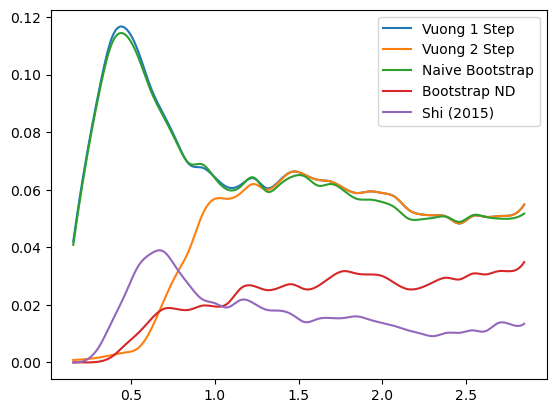

In [5]:
def create_fig(params,res,name='test.png'):
    results2 = np.array(res)
    
    col_labels = ['Param','Vuong 1 Step','Vuong 2 Step', 'Refinement Test','Shi (2015)', 'Naive Bootstrap','Bootstrap TIC','Bootstrap ND']



    np_results = np.concatenate((params.reshape(params.shape[0],1),results2[:,:,0]),axis=1)
    df_results = pd.DataFrame(data=np_results,columns=col_labels)
    df_results.to_csv("paper_figs5/"+name[:-4]+".csv")
    
    ma2 = lambda x : np.convolve(x,np.ones(smoothing)/smoothing, mode='valid')
    params_new = np.linspace( ma2(params).min(),  ma2(params).max(), 300) 
    interp = lambda x: make_interp_spline(ma2(params), ma2(x), k=3)(params_new)


    plt.plot(params_new, interp(1-results2[:,0,0]) ,label='Vuong 1 Step')
    plt.plot(params_new, interp(1-results2[:,1,0]) ,label='Vuong 2 Step')
    
    if not skip_boot:
        plt.plot(params_new,interp(1-results2[:,4,0]),label='Naive Bootstrap')
        plt.plot(params_new,interp(1-results2[:,6,0]),label='Bootstrap ND')
        
    if not skip_shi:
        plt.plot(params_new,interp(1-results2[:,3,0]),label='Shi (2015)')

    plt.legend()
    plt.savefig('paper_figs5/'+name,dpi=300)
    plt.show()

name = 'size_nobs%s_c1%s_c2%s_trials%s.png'%(nobs,c1,c2,trials)
create_fig(betas,results,name=name)

# Power stuff

0.15808144351056103 -1.0049776578163978 4.290264832809557
-4.326120614407229 -1.0049776578163978 -0.19393722510823364
---
-0.46063085070080395 -0.4580708266089336 3.4966075846780305
-3.595157954282932 -0.4580708266089336 0.36208048109590185
---
0.01593361180451293 -0.7838937173340422 3.9319532290926866
-4.090108192228223 -0.7838937173340422 -0.17408857494004984
---
-0.9754859601250665 -0.1480152938509813 2.97161374168632
-2.815028904762352 -0.1480152938509813 1.1320707970490345
---
-0.8787498797681382 -0.6141854502047511 3.300188054125397
-3.2790777320100455 -0.6141854502047511 0.8998602018834898
---
1.1605048808291307 -1.4062033958786035 4.8540900361429005
-4.96867744188384 -1.4062033958786035 -1.2750922865700711
---
0.3680778047148639 -1.7940894597213086 4.358050053262995
-4.656156298928782 -1.7940894597213086 -0.6661840503806514
---
-0.4452779925929926 -0.659670958840552 3.657574450044742
-3.4443825962363652 -0.659670958840552 0.6584698464013692
---
-1.7226750018670067 1.39935776387

-0.7548806836960178 -0.788219997537388 3.1070304912085933
-2.881381819067585 -0.788219997537388 0.9805293558370256
---
-1.5365396449726598 0.5109053198388882 2.435809617255172
-2.495570613584703 0.5109053198388882 1.4767786486431296
---
-0.3658545029415589 -0.43610585185242107 3.4746190263325243
-3.372832011898975 -0.43610585185242107 0.46764151737510823
---
2.8085760667525745 -3.158671089710649 6.502884226609363
-6.3298274806484525 -3.158671089710649 -2.635519320791665
---
-1.4490158253254917 0.5782863220922461 2.5271907271272913
-2.5678918239548967 0.5782863220922461 1.4083147284978863
---
-0.38206929420480634 -0.5160438110166491 3.4417450441388833
-3.505664311478253 -0.5160438110166491 0.31815002686543664
---
-1.3682172544708777 0.5497382669077278 2.5629710918897137
-2.3755125501392116 0.5497382669077278 1.5556757962213803
---
3.4267141479501406 -3.476246913330751 7.503010361269182
-7.704449154278627 -3.476246913330751 -3.628152940959585
---
-0.6171059372962349 -0.3614933996419949 3

-1.175314003356896 0.14714649313345496 2.713597346329626
-2.620850348090182 0.14714649313345496 1.2680610015963403
---
6.435270168615904 -4.954801930740498 10.190503765599155
-10.46434037052769 -4.954801930740498 -6.709106773544439
---
-1.179448787334419 -0.2863035684820044 2.949717905678776
-2.8234362881903476 -0.2863035684820044 1.3057304048228475
---
4.387878976523296 -5.465015290375447 8.9541645665555
-9.250409783185138 -5.465015290375447 -4.6841241931529325
---
-1.4227006865415572 0.3845112839120033 2.572184505290772
-2.5323687195558495 0.3845112839120033 1.4625164722764792
---
0.6427298160109471 -2.078394801168036 4.515399214192167
-4.602834446056187 -2.078394801168036 -0.7301650478749678
---
-0.8878166654635199 -1.116190483127606 3.0885675356576043
-3.2775560096279897 -1.116190483127606 0.6988281914931347
---
-0.6612305713479467 -0.9887389989382734 3.2328664461826535
-3.399204306349755 -0.9887389989382734 0.4948927111808452
---
-1.3567515471669904 0.6302338402033297 2.4951479572

-1.2548683020160711 -0.3148289087751023 2.6304816360657823
-2.6913864245086367 -0.3148289087751023 1.1939635135732165
---
-0.4833028954634107 -1.7600018444583954 3.5906871045985493
-3.759975940945527 -1.7600018444583954 0.31401405911643304
---
1.9517253767021159 -3.807592464308827 6.158587806350054
-6.019742510036416 -3.807592464308827 -1.8128800803884781
---
-1.4668507014021914 0.029814120520782948 2.4567021628265167
-2.82462886775401 0.029814120520782948 1.0989239964746977
---
-1.1650674801462475 -0.500088007497284 2.7795947320361143
-3.075282424740279 -0.500088007497284 0.8693797874420823
---
-0.6809165146810385 -1.4419182668765702 3.240100456830296
-3.3326183566147054 -1.4419182668765702 0.5883986148966281
---
1.4186967311244174 -4.152100235681202 5.520498100115775
-5.6308173840991715 -4.152100235681202 -1.5290160151078145
---
0.6481594168369935 -3.51472139643113 4.578817498033327
-4.9638028978778275 -3.51472139643113 -1.0331448166814934
---
-0.6871428692591673 -1.7366114776778192 

-1.3937371248276549 0.0026402019312522867 2.5354717146661203
-2.408005349201039 0.0026402019312522867 1.5212034902927358
---
-0.6829956199553722 -1.7938641157003123 3.208961132836936
-3.289522573696051 -1.7938641157003123 0.6024341790962568
---
-1.4836603414003373 -0.26986203245406915 2.44655504252098
-2.471304840567872 -0.26986203245406915 1.4589105433534453
---
0.38041315675400017 -5.09530140279251 4.839656725163247
-5.467674851340166 -5.09530140279251 -1.0084312829309185
---
-0.32310289029342154 -3.220345786006672 3.5710700526955703
-3.5519193861097236 -3.220345786006672 0.34225355687926795
---
-1.5022648595753025 -0.2949254997227047 2.5135655413759252
-2.4957437547623855 -0.2949254997227047 1.520086646188843
---
0.7275570361991018 -4.569584185738233 4.842329696232623
-4.886332889924368 -4.569584185738233 -0.7715602298908475
---
-1.4700599942249117 -0.4588302962721839 2.4567398441094226
-2.6246063800000075 -0.4588302962721839 1.3021934583343266
---
-1.0144808662403002 -2.31645914704

-1.6954093641954542 0.20264089065560362 2.3872168503916313
-2.394606607407317 0.20264089065560362 1.6880196071797688
---
-1.4991480996161275 -0.8807512386411752 2.4648422318627796
-2.6456911412768047 -0.8807512386411752 1.318299190202102
---
-1.4335519471537248 -2.812960546536211 2.7973110238697556
-3.1965559575823814 -2.812960546536211 1.034307013441099
---
-1.0252986567151872 -3.6632385291588956 3.103816518311081
-3.3028042730658664 -3.6632385291588956 0.8263109019604015
---
-1.3189354353515923 -1.6341931363438835 2.723530636859594
-2.8027358013132715 -1.6341931363438835 1.2397302708979152
---
-1.5178332074649168 -0.31398161397561763 2.4385084936597
-2.460021135808918 -0.31398161397561763 1.4963205653156988
---
-0.8010144009628252 -2.4893646970378267 3.0219740969551103
-3.0524503758355688 -2.4893646970378267 0.7705381220823667
---
-0.47513136823155266 -5.618475212543834 3.761007778637
-3.9476166224374736 -5.618475212543834 0.288522524431079
---
0.002836876110540136 -6.116286691947697

-0.21404702041095838 -5.219538478923443 3.44408936424749
-3.7906737009170857 -5.219538478923443 -0.1325373162586379
---
-0.9623971032010482 -4.165434252960831 3.531519889794117
-3.642346557644687 -4.165434252960831 0.8515704353504779
---
-1.568965338123031 -0.2478421522522697 2.329509647452487
-2.343023704155048 -0.2478421522522697 1.5554512814204695
---
-1.3367152220846454 -1.1622957621804548 2.4336439122430753
-2.376790938521313 -1.1622957621804548 1.3935681958064083
---
-1.0835066954878154 -3.6924229924560077 2.90473722415542
-3.1323779524885724 -3.6924229924560077 0.8558659671546629
---
-1.512084895178097 -1.108102352286801 2.500280411841842
-2.610001878809945 -1.108102352286801 1.4023634282099937
---
-0.40220359798524113 -6.091141998955687 4.005816110527407
-4.175181741508061 -6.091141998955687 0.2328379670045871
---
-1.0485564885107328 -3.976582842952736 3.0944721324235616
-3.3136540115014883 -3.976582842952736 0.8293746094328058
---
-0.8209475063768874 -6.258043623269098 3.55062

-0.8608179845248239 -5.428674077633972 3.166116030177708
-3.214047547720266 -5.428674077633972 0.812886466982266
---
-1.4327489236813828 -1.7717182398774673 2.316134391520203
-2.384524720493878 -1.7717182398774673 1.3643585947077081
---
-1.3435110072590464 -9.164853777317896 4.221647316525423
-4.645113921880488 -9.164853777317896 0.9200444019039817
---
-1.554946480227342 -1.1802979688184192 2.4217152814189475
-2.427537974458301 -1.1802979688184192 1.5491237871879888
---
-1.2098587960372416 -4.9140944029496545 2.93235698538557
-3.2105437850004885 -4.9140944029496545 0.931671996422323
---
-0.898766086359159 -3.4735798054914824 2.6359801968184238
-2.756861081052583 -3.4735798054914824 0.7778852021249997
---
-1.3977568578780313 -1.7453510431618653 2.5549024759690533
-2.558229224003464 -1.7453510431618653 1.394430109843621
---
-0.5852055934447775 -5.927096779286126 3.6213144763994736
-3.85821621312045 -5.927096779286126 0.34830385672380104
---
-0.7920556263558545 -6.316522667794509 3.605608

-1.194574336793078 -4.995124119986628 2.895511509146907
-3.0660760704270347 -4.995124119986628 1.0240097755129502
---
-1.3033267563107294 -4.8437712665481785 2.7626660402621424
-2.806392943377062 -4.8437712665481785 1.2595998531958097
---
-1.2966964818752214 -8.574004775129834 3.3613678529797
-4.002083760724741 -8.574004775129834 0.655980574130181
---
-1.0820293952289464 -7.681486726504955 3.547193992104797
-4.102543972598717 -7.681486726504955 0.5266794147350268
---
-1.3784008595060953 -3.7646717074244522 2.533918402443399
-2.6481627636147924 -3.7646717074244522 1.2641564983347018
---
-1.6217614320969302 -2.5214681779087518 2.4341052600908553
-2.594631020399989 -2.5214681779087518 1.4612356717877961
---
-1.3352688526082575 -5.239045320936883 2.887940159694911
-3.0381602367731912 -5.239045320936883 1.1850487755299772
---
-1.3893793881490675 -6.1184182842872525 3.13047616197211
-3.4124793452386717 -6.1184182842872525 1.107376204882506
---
-1.457690891929091 -3.065515270107915 2.60445411

-1.9048104036004199 -7.865507838819181 2.9333155860957683
-3.6101507806193296 -7.865507838819181 1.227975209076858
---
-1.7581169414186528 -10.709921863506574 3.6447391245285803
-4.345334987607092 -10.709921863506574 1.0575210783401416
---
-1.6239370038136685 -5.446377254459966 2.8163537362532094
-3.2298731374385565 -5.446377254459966 1.2104176026283218
---
-1.1220230784842578 -7.227554275667232 2.8817126361028023
-3.011666403949918 -7.227554275667232 0.9920693106371421
---
-1.4090585627269963 -3.7315069460679267 2.525126087190759
-2.6975981295604883 -3.7315069460679267 1.2365865203572668
---
-1.6360843864336159 -5.199828074570898 2.7469589939306096
-3.125862318811305 -5.199828074570898 1.2571810615529206
---
-1.486320315793056 -8.741794037257707 3.4511244312650513
-3.846960381374259 -8.741794037257707 1.0904843656838483
---
-1.180784019676873 -7.065069144100906 2.9822603415812887
-3.2166783947825515 -7.065069144100906 0.9463659664756102
---
-1.5040122468154442 -4.803755982241213 2.565

-1.5770586166576066 -3.850760586121827 2.504802803864321
-2.711416973692238 -3.850760586121827 1.37044444682969
---
-1.4167031341562069 -4.365816757534272 2.5266837075000947
-2.658256236769383 -4.365816757534272 1.2851306048869184
---
-1.6153737523774536 -5.526325083218677 2.856202657252494
-3.1629824723935602 -5.526325083218677 1.308593937236387
---
-1.8867189095528558 -5.926907401587929 2.749824553017646
-3.211457190830829 -5.926907401587929 1.4250862717396726
---
-1.3721642239473744 -9.240499466532437 3.089408515985339
-3.396921790907348 -9.240499466532437 1.0646509490253657
---
-2.160691471880538 -10.06224512565788 3.735521247147438
-4.470970378395433 -10.06224512565788 1.4252423406325434
---
-1.9569946161502365 -5.393883084819975 2.803857505177491
-3.3614373245406677 -5.393883084819975 1.39941479678706
---
-1.7229307346027618 -3.1906603131645017 2.5625267548133994
-2.6309994488502477 -3.1906603131645017 1.6544580405659133
---
-2.0078959407730714 -7.925359657225912 3.19759826824595

-1.6714952111641077 -4.822878735964069 2.4949957194557415
-2.666692184190404 -4.822878735964069 1.4997987464294456
---
-2.248343475277143 -7.959783858159302 2.935375694592816
-3.7494779733625787 -7.959783858159302 1.4342411965073807
---
-1.3631054186230316 -10.17689569677208 3.0094335988849923
-3.3019671943867612 -10.17689569677208 1.0705718231212624
---
-2.3109907816752817 -10.428696177004491 3.1713388782399266
-4.028726629965237 -10.428696177004491 1.4536030299499718
---
-2.2495360710149135 -7.248250871121529 2.838555990071141
-3.5163816508542314 -7.248250871121529 1.5717104102318227
---
-1.6205376619334897 -4.8939003624768755 2.2573068234602376
-2.6419886278117524 -4.8939003624768755 1.235855857581975
---
-1.776373664911196 -2.5947629259072786 2.3544087610217814
-2.502905381248911 -2.5947629259072786 1.6278770446840667
---
-1.7528699595545896 -6.445660541891457 2.696758276214967
-2.9063168505373445 -6.445660541891457 1.543311385232212
---
-1.7175448540320815 -5.272529153064272 2.551

-1.961365452901466 -6.372299893960518 2.540668334111045
-3.1071938582239507 -6.372299893960518 1.3948399287885602
---
-1.6907740096193422 -11.155333202974633 2.8530341738580436
-3.3687065462782093 -11.155333202974633 1.1751016371991767
---
-1.980791687794301 -10.390907494778933 3.262352322636359
-3.796775098286876 -10.390907494778933 1.4463689121437837
---
-1.7955713807408311 -8.557533897223381 2.8628423270722143
-3.3450759492762256 -8.557533897223381 1.3133377585368198
---
-2.523840280338338 -10.799744121937854 3.2266170059347457
-4.107536047381365 -10.799744121937854 1.6429212388917185
---
-2.1682776489600504 -7.813355312022618 2.70655860395386
-3.482726156348075 -7.813355312022618 1.3921100965658357
---
-1.6675503658857753 -10.957591638761519 2.7156727049494838
-3.37999682259343 -10.957591638761519 1.003226248241829
---
-1.7426355119840093 -9.229607065562934 2.920264068091178
-3.2971258251825764 -9.229607065562934 1.365773754892611
---
-1.7441815206297102 -9.368748810340293 2.711025

-2.6526033338171557 -13.75871427817859 3.3881592622177266
-4.429087551885373 -13.75871427817859 1.6116750441495087
---
-1.6944550899024546 -10.686566225152706 2.787058893631613
-3.249213592713172 -10.686566225152706 1.2323003908208956
---
-2.431861204167018 -15.108739002952078 3.5785273890133946
-4.4214738194062955 -15.108739002952078 1.5889147737741163
---
-1.845207363225856 -8.170142096367739 2.4745666537015527
-2.8806577014416637 -8.170142096367739 1.4391163154857454
---
-1.831179761621557 -3.305428513411652 2.223752145522177
-2.5034453199336215 -3.305428513411652 1.5514865872101122
---
-2.045927758048523 -7.914253898842543 2.623423853278355
-3.0822193211788265 -7.914253898842543 1.5871322901480516
---
-1.8721088154545316 -12.511662767547898 2.9683288783158503
-3.614466876332449 -12.511662767547898 1.225970817437933
---
-2.0194188373330753 -12.64940627766748 2.960064578710855
-3.7550159412654547 -12.64940627766748 1.224467474778475
---
-2.3934252830719833 -11.823839532910581 3.69322

-1.8058171506345697 -6.25860721576347 2.4787653965974084
-2.6699672397156204 -6.25860721576347 1.6146153075163578
---
-2.4145249426731588 -13.246224371857224 3.3250118834675946
-3.8024865395070067 -13.246224371857224 1.937050286633747
---
-1.9503752303972504 -9.110009866539773 2.4553237858584414
-3.1379045567069475 -9.110009866539773 1.2677944595487443
---
-1.9114740503910561 -8.441143546978605 2.6281888169072465
-2.9864832020995835 -8.441143546978605 1.5531796651987195
---
-1.7584041146208298 -9.205161782260724 2.525613284146051
-2.906927696443171 -9.205161782260724 1.3770897023237099
---
-1.7541330235852794 -13.673178456309245 2.7129264478908603
-3.2989659711006896 -13.673178456309245 1.1680935003754505
---
-2.5390401934817564 -12.409702420445038 3.1698681385133813
-3.9945583277106906 -12.409702420445038 1.714350004284447
---
-3.227863342047298 -12.499139913432442 3.982965961692185
-4.762877721228122 -12.499139913432442 2.447951582511361
---
-2.2250414808156327 -12.964083075851502 3.

-1.8066981559212956 -7.898908324321825 2.4288049605863433
-2.7023051862596406 -7.898908324321825 1.5331979302479979
---
-1.9647270419302774 -9.348976484350949 2.2945845090270893
-2.9127069709591424 -9.348976484350949 1.346604579998224
---
-2.0417763896896073 -15.7869344649879 2.881382387775704
-3.4298945053313536 -15.7869344649879 1.4932642721339573
---
-2.1517984270122295 -15.237296303370238 2.9782999046217817
-3.724091746695505 -15.237296303370238 1.4060065849385064
---
-2.6464366923509655 -14.313792974729116 3.1799177814546984
-4.061109943978336 -14.313792974729116 1.7652445298273283
---
-1.6788226182901869 -10.645906951091028 2.4917093383457605
-2.814434480662482 -10.645906951091028 1.3560974759734652
---
-1.7764252030254228 -12.949341132713684 2.6829285616037173
-3.1386416129800185 -12.949341132713684 1.3207121516491216
---
-1.8668477039224392 -6.639899879536836 2.0328206244718605
-2.528189115862889 -6.639899879536836 1.3714792125314106
---
-2.252430653318569 -7.922639429272059 2.

-2.3252895634773982 -8.804280998594278 2.550017167612445
-3.1361228691899004 -8.804280998594278 1.7391838618999425
---
-2.671690471258669 -16.364268060403926 3.1699384412165137
-4.116254542729987 -16.364268060403926 1.7253743697451953
---
-2.4695796542180495 -15.726952889507261 3.051697439095794
-3.824993975808153 -15.726952889507261 1.6962831175056905
---
-1.9609370901096554 -10.341546452737004 2.478018555387679
-2.964323932211533 -10.341546452737004 1.4746317132858011
---
-3.1371405589867054 -12.232345069574649 3.201921248839183
-4.174476650180312 -12.232345069574649 2.164585157645577
---
-2.2021209486006454 -12.269701454143751 2.8634931698599058
-3.2840648279563713 -12.269701454143751 1.7815492905041797
---
-2.122114620989134 -7.393687120790277 2.2648640043642416
-2.829645206771938 -7.393687120790277 1.5573334185814378
---
-2.602895659836018 -10.497418748989208 2.8330641804731806
-3.534936344238022 -10.497418748989208 1.9010234960711763
---
-2.3878422003926385 -11.632238744250296 2.

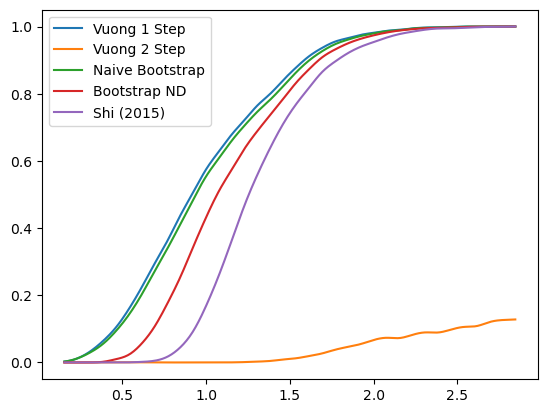

In [6]:
def gen_data3(beta= 1.5, nobs=1000):
    cov = [[25, 0], [0, 1]]
    data = np.random.multivariate_normal([0,beta], [[25,0],[0,1]],  nobs)
    return data[:,0],data[:,1],nobs

betas = np.linspace(0,3,linspace)
nobs = 100
c1,c2 = calc_c(nobs)
results = []


for beta in betas:
    setup_shi_ex  = lambda yn,xn: setup_shi(yn,xn)
    gen_data_ex = lambda : gen_data3(nobs=nobs, beta =beta)
    mc_out = vuong_tests_fast.monte_carlo(nsims,gen_data_ex,setup_shi_ex,trials=trials,
                                          skip_boot=skip_boot,skip_shi=skip_shi,refinement_test=refinement_test,c1=c1,c2=c2)
    reg,twostep, refine_test, boot1,boot2,boot3,shi, llr,std, omega = mc_out
    results.append([reg,twostep,refine_test,shi,boot1,boot2,boot3])

name = 'power_nobs%s_c1%s_c2%s_trials%s.png'%(nobs,c1,c2,trials)
create_fig(betas,results,name=name)

# extra size sims

5.190356073012397 -2.206591573422131 9.18249412592846
-9.103742649594158 -2.206591573422131 -5.111604596678095
---
4.595239974642861 -1.9626208621351615 8.668664169606032
-8.572531794064805 -1.9626208621351615 -4.499107599101635
---
7.278318379827947 -2.8931387983475645 11.151222540871897
-11.17137752074079 -2.8931387983475645 -7.298473359696841
---
5.751825022164748 -2.3631474090094904 9.825677223432386
-9.929084192964773 -2.3631474090094904 -5.855231991697136
---
1.770370670738962 -0.9463283839325638 5.909234837449875
-5.895203506343606 -0.9463283839325638 -1.7563393396326918
---
-1.1625036268190083 1.2015927001253832 2.4916138938080445
-2.426035814356595 1.2015927001253832 1.228081706270457
---
1.2087986079627335 -0.8470898434029216 5.149971455402293
-5.055732840088993 -0.8470898434029216 -1.114559992649434
---
-0.7806137632394605 0.1615560759371922 3.1311717277808437
-3.260931763980244 0.1615560759371922 0.65085372704006
---
-0.27707300887428626 -0.1734774052754768 3.73100683258709

0.04328212120805191 -0.005178834772792257 4.082351537488792
-3.8209284744955925 -0.005178834772792257 0.21814094178514845
---
-0.5914204963326387 -0.2727244875236079 3.432516968286036
-3.244434138394851 -0.2727244875236079 0.7795033262238235
---
-0.9097159495670882 0.2939644148384809 2.935167728322024
-3.0355892511828473 0.2939644148384809 0.8092944267062648
---
7.1738766451888845 -3.5031397536980764 11.055164155270612
-11.188218316135123 -3.5031397536980764 -7.306930806053396
---
3.915772560294931 -2.453120088949447 7.963082049983455
-7.975853089552089 -2.453120088949447 -3.928543599863566
---
-0.34394980016158433 -0.03909714056643539 3.6386678515224853
-3.6404250341267983 -0.03909714056643539 0.34219261755727154
---
0.02852831335277603 -0.420382391726231 3.821942048478608
-3.816562610912342 -0.420382391726231 -0.0231488757865092
---
1.1478180946136385 -0.8575389010269528 5.142914926316433
-5.222764626225971 -0.8575389010269528 -1.2276677945231775
---
-0.798820345383741 0.185019173397

-0.779623204292667 0.16107178699609404 3.0531053533799604
-3.0012989619076604 0.16107178699609404 0.8314295957649674
---
0.567586015824553 -1.2219334904090453 4.593498694356643
-4.752108440575524 -1.2219334904090453 -0.726195762043434
---
-0.6088731284579484 0.10318806300090537 3.188714934845666
-3.1757656700417956 0.10318806300090537 0.6218223932618184
---
[1. 0. 0.]
-1.024586746870456 -0.6678162432863265 3.1394248845586286
-3.3274111439832015 -0.6678162432863265 0.8366004874458832
---
-0.7529612313622964 -0.6460871979354256 3.3755816369190987
-3.417144856008796 -0.6460871979354256 0.7113980122725994
---
-0.2577409409748746 -1.432030968780721 3.608429402651584
-3.5838956126775097 -1.432030968780721 0.28227473094894917
---
1.3917462632511146 -1.9436303370478005 5.385218266621569
-5.387805247621129 -1.9436303370478005 -1.3943332442506742
---
3.2103607495288107 -4.277270231745561 6.973469107800387
-7.094155035659038 -4.277270231745561 -3.331046677387462
---
3.5762553821605367 -4.35743803

-0.7442626059989089 -0.5786363841724593 2.9376042038103423
-2.697402298125063 -0.5786363841724593 0.9844645116841875
---
-1.1431140499281878 0.11146678344374326 2.5537180712023186
-2.7618454254971363 0.11146678344374326 0.9349866956333699
---
-1.186615318769906 0.06431861358124266 2.6727687024534537
-2.630674489984322 0.06431861358124266 1.228709531239037
---
0.3095462716184329 -2.4893815799627785 4.006279097168476
-4.0325221282046435 -2.4893815799627785 -0.3357893026546
---
-1.2503733480526698 -0.0013833704731245219 2.4959624650832004
-2.675239844636017 -0.0013833704731245219 1.0710959684998527
---
-1.4523224681377658 0.07776006267381708 2.6196249246626406
-2.8017213259790146 0.07776006267381708 1.2702260668213918
---
-0.541146044294975 -1.136856741609233 3.4136460005048175
-3.3513030444234753 -1.136856741609233 0.6034890003763175
---
-1.0308335321686486 -0.0933089338614317 2.779269560694068
-2.59085518116083 -0.0933089338614317 1.219247911701887
---
-1.3763294116061804 1.332002489063

-1.1901991741594948 -0.2642893811520246 2.7325889743140563
-2.680579060985551 -0.2642893811520246 1.2422090874879992
---
-1.232785447278422 -0.2145255634608971 2.841019221043858
-2.8304417460923936 -0.2145255634608971 1.2433629222298868
---
-0.7987531462530802 -1.480138924819395 2.999966539233661
-2.8989726352898977 -1.480138924819395 0.8997470501968433
---
-1.4135747303273938 0.4920466253229495 2.5004257461889896
-2.497253766907569 0.4920466253229495 1.4167467096088144
---
-0.3524746989958284 -3.067444584224584 3.637676080338728
-3.7257890160776896 -3.067444584224584 0.2643617632568667
---
-0.6850727544184229 -2.0397411507437626 3.1833565774990515
-3.4444609537310193 -2.0397411507437626 0.423968378186455
---
-1.4930192610497892 0.7149279579327451 2.291046775597104
-2.394581955346177 0.7149279579327451 1.389484081300716
---
[0.96714286 0.         0.03285714]
-1.3675955080586946 -0.060393464346179225 2.3621647724822687
-2.5799400250596904 -0.060393464346179225 1.1498202554812729
---
-1.

-1.3063140900950878 -0.8026285201859353 2.509165082358909
-2.4870046757465705 -0.8026285201859353 1.3284744967074265
---
-1.5572952373519546 0.8994398562427782 2.498324154021465
-2.3227935583900146 0.8994398562427782 1.732825832983405
---
-1.4164939801558534 -0.6780482534946484 2.5576988718914713
-2.497339478490593 -0.6780482534946484 1.4768533735567317
---
-1.434844009554472 -1.133381807065243 2.576217250200713
-2.6591484425882244 -1.133381807065243 1.3519128171669608
---
-1.672736582912008 1.3090660373631888 2.2701573337437315
-2.302021227777271 1.3090660373631888 1.6408726888784684
---
-0.9135912033725262 -3.620286016431737 3.2744934780172517
-3.3614769140366882 -3.620286016431737 0.8266077673530899
---
-1.5529793909174214 -0.501594199909928 2.4775080784501755
-2.7125938066391497 -0.501594199909928 1.3178936627284472
---
-1.5331881783521417 -0.7320316050515847 2.435387443779624
-2.7287831654783554 -0.7320316050515847 1.2397924566534113
---
-0.8355762615025114 -2.289241838360478 3.11

-1.5011665165327144 -0.6736510311358395 2.470913659830285
-2.4349038664674323 -0.6736510311358395 1.5371763098955673
---
-1.3480519653175094 -0.8005886531281761 2.452033544830883
-2.529583066338995 -0.8005886531281761 1.2705024438093977
---
-1.4071322493203362 -1.3620755449594901 2.368762446934707
-2.5199567807784256 -1.3620755449594901 1.2559379154766175
---
-1.5504651680368624 0.9486188649301701 2.3048903788178343
-2.1689874764626524 0.9486188649301701 1.6863680703920443
---
-1.3728396127239937 -0.8451844668412146 2.5496405123950288
-2.6443146430744737 -0.8451844668412146 1.2781654820445487
---
-1.5725892219537614 0.2480122085043869 2.596492521708989
-2.3916551751264823 0.2480122085043869 1.777426568536268
---
-1.5831252316518822 0.07435250064679055 2.2761431394771403
-2.396075604269422 0.07435250064679055 1.4631927668596008
---
-1.3153278898216438 -0.7892620668065137 2.5418175465517137
-2.3671974845852697 -0.7892620668065137 1.489947951788088
---
-1.6638679335323843 0.96500040734766

-1.5191085005623735 -0.20753847725376762 2.2676081980901057
-2.3880762205536405 -0.20753847725376762 1.3986404780988388
---
-1.671704378738915 0.7189393907887988 2.3216814910357573
-2.2851024627107734 0.7189393907887988 1.7082834070638993
---
-1.6299743435534757 0.17830152740602942 2.2326670928636627
-2.3732047497419795 0.17830152740602942 1.4894366866751592
---
-1.500367498300454 -2.144154612685986 2.64808717147309
-2.6099307972314665 -2.144154612685986 1.5385238725420771
---
-1.788153785380997 0.2566986343043609 2.3989479968278307
-2.4462281601154885 0.2566986343043609 1.7408736220933392
---
-1.3713557695803293 -1.2845906455666558 2.5205230065382445
-2.4484080745024475 -1.2845906455666558 1.4434707016161268
---
-1.619240683036407 -2.1571652828341037 2.354752321324323
-2.68065609962346 -2.1571652828341037 1.2933369047372703
---
-1.7930219935485956 1.2908605720612567 2.159723221319028
-2.236770709444621 1.2908605720612567 1.7159745054230022
---
-1.4477166303864861 -0.5283797893099076 2

-1.6165181880884378 0.5208104590433834 2.195346304869863
-2.226458484925279 0.5208104590433834 1.5854060080330215
---
-1.6035007523412665 0.5489176984804007 2.3072715930060554
-2.2232926811413063 0.5489176984804007 1.687479664206016
---
-1.5308477821214153 -0.37162225443136365 2.1053221957143884
-2.1947967319243427 -0.37162225443136365 1.4413732459114605
---
-1.6855926604050362 0.1916912682651692 2.383508151098899
-2.2952741711362137 0.1916912682651692 1.7738266403677219
---
-1.6331318293084447 0.16355321481085489 2.0971862841369453
-2.3235413311664224 0.16355321481085489 1.4067767822789679
---
-1.7594502192359764 -0.3898455649720259 2.320621544971964
-2.449165404466729 -0.3898455649720259 1.6309063597412117
---
-1.5421410475262265 -0.7016686203316134 2.3851885702535567
-2.228742947152207 -0.7016686203316134 1.6985866706275765
---
-1.6685268868214154 0.22297345553795003 2.237132945613357
-2.2889383307372544 0.22297345553795003 1.616721501697518
---
-1.4504104501337791 0.740622123083785

-1.7107392447300875 0.8266249114727741 2.308723632400916
-2.179734616839967 0.8266249114727741 1.8397282602910368
---
-1.6201851159367908 0.3890043822751047 2.3869250593305376
-2.1943420303497794 0.3890043822751047 1.8127681449175492
---
[0.96428571 0.00428571 0.03142857]
-1.6133796562297584 -1.6311086200700946 2.3149676299543085
-2.329689408932329 -1.6311086200700946 1.5986578772517381
---
-1.6844374256656907 -0.7543113401668226 2.277860384192565
-2.347335883482011 -0.7543113401668226 1.614961926376245
---
-1.5013939536142957 -2.3646738718950493 2.343695258643803
-2.432626214010439 -2.3646738718950493 1.41246299824766
---
-1.7368433438462083 -0.5035151414350717 2.164045335522531
-2.312696759978394 -0.5035151414350717 1.5881919193903455
---
-1.5884541336877418 -0.7268005509038962 2.258655910023131
-2.2069183632386387 -0.7268005509038962 1.640191680472234
---
-1.672800837318014 0.27478408316100206 2.231972594908186
-2.2157394725272455 0.27478408316100206 1.6890339596989545
---
-1.678141

-1.6154006270394439 -0.19101503423577224 2.211712181894552
-2.176666979163531 -0.19101503423577224 1.650445829770465
---
-1.4768931376053471 -4.064962358645332 2.4584871887544413
-2.3639162941319665 -4.064962358645332 1.571464032227822
---
-1.6296033113046373 -1.335221789517352 2.399245740818142
-2.2296202123291198 -1.335221789517352 1.79922883979366
---
-1.7111901132324114 -0.2801647838682754 2.2213859174901067
-2.253906726999347 -0.2801647838682754 1.678669303723171
---
-1.919240637566691 2.26480091871439 2.3097680360692756
-2.2863947022752873 2.26480091871439 1.9426139713606791
---
-1.4678080452609719 -3.8714816009338824 2.4129024921981506
-2.42384107114483 -3.8714816009338824 1.4568694663142925
---
-1.4246100300511206 -3.597285136841768 2.3548761831091496
-2.2949427745132014 -3.597285136841768 1.4845434386470688
---
-1.8253569977727526 1.3104228591794227 2.308729857905458
-2.2683932303844534 1.3104228591794227 1.865693625293757
---
-1.80676425739379 0.604731382985182 2.341426246519

-1.7533033635867667 -0.44488013793255704 2.121045327148441
-2.244796982618937 -0.44488013793255704 1.6295517081162705
---
-1.8645377384981332 -1.800135613694812 2.1870236231830966
-2.494427212674431 -1.800135613694812 1.5571341490067983
---
-1.7302366111732204 0.9608364960843297 2.0558123042837146
-2.1536869769260996 0.9608364960843297 1.6323619385308352
---
-1.9614575181134726 -0.831381870961623 2.214959212738888
-2.5022190702049416 -0.831381870961623 1.6741976606474187
---
-1.859999005786522 2.494622671488918 2.1485547215211573
-2.2243042861267615 2.494622671488918 1.784249441180918
---
-1.8066849669327187 1.432147974758246 2.0500330234632163
-2.1872568723864267 1.432147974758246 1.6694611180095082
---
[0.96285714 0.00714286 0.03      ]
-1.7345671537146077 -0.4007478179669156 2.09105759170318
-2.2238500523026987 -0.4007478179669156 1.6017746931150887
---
-1.7350519636642905 0.22491225552446895 2.186105921318284
-2.143824692800438 0.22491225552446895 1.7773331921821367
---
-1.77299695

-1.7870475666891836 0.2905534228199611 2.2222685903548713
-2.2167169819212633 0.2905534228199611 1.7925991751227919
---
-1.6445859431354617 -2.4249435567438367 2.190465056563239
-2.228550808193834 -2.4249435567438367 1.6065001915048664
---
-1.623336710785846 -0.03186069380684687 2.2062946766692924
-2.0690943002147755 -0.03186069380684687 1.760537087240363
---
-1.7358481438474944 -1.7852974976479854 2.225360994632293
-2.2846623201027523 -1.7852974976479854 1.6765468183770358
---
-1.6622018046749787 0.5966927332506923 2.303485875889403
-2.054014388336423 0.5966927332506923 1.9116732922279587
---
-1.7348430423849968 -0.37148916806781046 2.24227319256152
-2.171367156126132 -0.37148916806781046 1.8057490788203843
---
-1.8486877070523928 -0.6666595243780304 2.0973374625509895
-2.285290440397238 -0.6666595243780304 1.660734729206144
---
-1.7303680094041587 1.1636113435671305 2.071087774338927
-2.087418090519661 1.1636113435671305 1.7140376932234247
---
-1.7023673556887666 0.2459385598234738 2

-1.624943881618496 0.39312027898320556 2.1302548243599264
-2.0307984826200114 0.39312027898320556 1.7244002233584115
---
-1.7937326335134514 -3.573620289085033 2.390438153091527
-2.4114313003754604 -3.573620289085033 1.772739486229518
---
-1.7364548943607288 1.2467520190035957 2.2100431065114257
-2.0935772889968804 1.2467520190035957 1.852920711875274
---
-1.7375819365590446 0.4680597529352366 2.1898131069934514
-2.132575625678912 0.4680597529352366 1.7948194178735841
---
-1.7156083249201013 0.5662106912950262 2.1330374779841232
-2.0968556435023187 0.5662106912950262 1.7517901594019059
---
-1.616397134673823 -1.7991733350794525 2.149191937630485
-2.1830165725605544 -1.7991733350794525 1.5825724997437536
---
-1.784165672456871 1.7256434712975552 2.0605929602664035
-2.1539973492073816 1.7256434712975552 1.6907612835158927
---
-1.7863804829908754 -2.0267303003589925 2.1691204813279605
-2.308747806013684 -2.0267303003589925 1.6467531583051522
---
-1.795933889395382 -1.2516064202346158 2.38

-1.8668283623476392 0.028161946593589695 2.1812075024621715
-2.2393346326690713 0.028161946593589695 1.8087012321407394
---
-1.697530675541434 -0.6463417801475925 2.2003286162176017
-2.1067484356943065 -0.6463417801475925 1.7911108560647295
---
-1.913680298721365 -0.19416544714103146 2.2345291914474954
-2.297973106834223 -0.19416544714103146 1.8502363833346376
---
-1.7463377867470804 -2.2609930191857432 2.2055306653182885
-2.2595499415524047 -2.2609930191857432 1.6923185105129641
---
-1.966280788416153 0.1868023681565258 2.1917721707165123
-2.344879015951575 0.1868023681565258 1.8131739431810905
---
-1.7891835669996659 0.03280795955997318 2.0838914632284924
-2.151504796570615 0.03280795955997318 1.7215702336575434
---
-1.7175173971905935 0.4605500496005383 2.18004192832601
-2.105777386687164 0.4605500496005383 1.7917819388294391
---
-1.7612884925946037 -0.6181003076194372 2.1476284169312034
-2.131511346127028 -0.6181003076194372 1.7774055633987789
---
-1.6959213070539656 -1.03818089455

-1.949724285858611 -1.9336975852297278 2.128243318281292
-2.4207194765537565 -1.9336975852297278 1.6572481275861466
---
-1.9886449927128214 -0.8277516724885826 2.077790158784773
-2.3795447068946145 -0.8277516724885826 1.6868904446029802
---
-1.8120304304205341 1.3302785743518202 2.1469781588488503
-2.120544307736878 1.3302785743518202 1.8384642815325059
---
-1.70275463033669 0.613638496101912 2.056976733947824
-2.029455498157005 0.613638496101912 1.7302758661275088
---
-1.7279966460598022 -0.35361428941053846 2.1939636770976922
-2.10841510845433 -0.35361428941053846 1.8135452147031645
---
-1.6955440741703807 -0.03186061633891681 2.28964144500718
-2.0557274524300175 -0.03186061633891681 1.929458066747543
---
-1.829438893766891 0.16303502370518722 2.132373454768433
-2.140940780191367 0.16303502370518722 1.8208715683439567
---
-1.764597828815584 0.14014519762137617 2.1125424746141332
-2.1299509991485293 0.14014519762137617 1.7471893042811883
---
-1.6994601527922726 -2.0858490006316286 2.1

-1.801026005348347 2.3971133042791046 2.1997498985432755
-2.046194046629488 2.3971133042791046 1.9545818572621347
---
-1.6915043447353442 0.37828507405118406 1.9698301338515873
-2.017032441535982 0.37828507405118406 1.6443020370509493
---
[0.96       0.01142857 0.02857143]
-1.8043831055828794 0.10320601332150249 2.1041277105839717
-2.1308425761785363 0.10320601332150249 1.7776682399883152
---
-1.8899942217543213 0.8084624426104857 2.181826646313275
-2.1696473861969663 0.8084624426104857 1.9021734818706302
---
-1.8470340798609626 -0.3116087988919344 2.0887441372287543
-2.177453457591415 -0.3116087988919344 1.7583247594983022
---
-1.7124985773968964 -1.28879320718948 2.289646091068048
-2.05732370712189 -1.28879320718948 1.9448209613430545
---
-1.6261596385141153 -0.5144629111819637 2.205580814649907
-1.9768025998466983 -0.5144629111819637 1.8549378533173237
---
-1.8927515118025962 1.7992151903700841 2.034503518500296
-2.178673998319479 1.7992151903700841 1.7485810319834134
---
-1.7975016

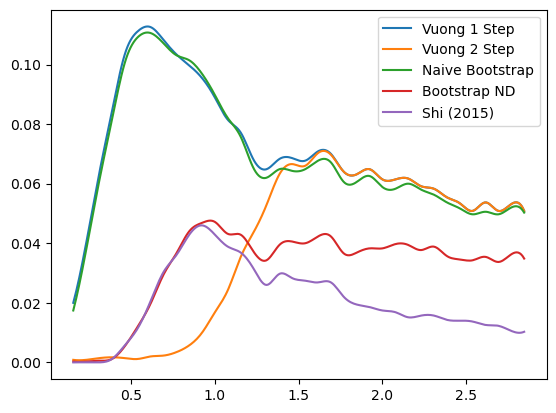

In [7]:
betas = np.linspace(0,3,linspace)
nobs =250
c1,c2 = calc_c(nobs)
results = []

for beta in betas:
    setup_shi_ex  = lambda yn,xn: setup_shi(yn,xn,num_params=num_params)
    gen_data_ex = lambda : gen_data(nobs=nobs, beta =beta)
    mc_out = vuong_tests_fast.monte_carlo(nsims,gen_data_ex,setup_shi,trials=trials,
                                          skip_boot=skip_boot,skip_shi=skip_shi,refinement_test=refinement_test,c1=c1,c2=c2)
    reg,twostep, refine_test, boot1,boot2,boot3,shi, llr,std, omega = mc_out
    results.append([reg,twostep,refine_test,shi,boot1,boot2,boot3])
    print(boot3)

name = 'size_nobs%s_c1%s_c2%s_trials%s.png'%(nobs,c1,c2,trials)
create_fig(betas,results,name=name)

0.6059831970200554 -1.7799317582170529 4.542153106447025
-4.802097796271196 -1.7799317582170529 -0.8659278868442268
---
-1.5082279447976656 0.5629612617793515 2.537262021760642
-2.502603991225958 0.5629612617793515 1.5428859753323496
---
-1.6301687718008446 0.5112301789474063 2.4753677619294243
-2.424337841545952 0.5112301789474063 1.681198692184317
---
-0.5771000261988197 -0.09449692782400224 3.313937759273178
-2.8724426767668474 -0.09449692782400224 1.0185951087051501
---
-0.9068111297560831 -0.14871133214226803 3.0949744413693976
-3.354967335574758 -0.14871133214226803 0.6468182355507228
---
-0.9121108604515973 -0.43580614649214267 3.060738124385916
-2.9467765299525266 -0.43580614649214267 1.0260724548849869
---
-1.4265373812251922 0.16629692736191745 2.672892745207365
-2.748421163583262 0.16629692736191745 1.3510089628492956
---
1.524961809368547 -2.025011272197431 5.3523225036318705
-5.163942392519067 -2.025011272197431 -1.336581698255743
---
-0.8643350816361902 -0.160517448256773

-1.6921039522688197 0.9127940720764292 2.3738512370194154
-2.3657998051516973 0.9127940720764292 1.7001553841365376
---
-0.9519413365904091 -0.28407049215859276 3.0975216495295634
-3.0810768307822545 -0.28407049215859276 0.9683861553377179
---
-1.2920822950317221 0.16286158190277053 2.61234870699577
-2.5141247724620768 0.16286158190277053 1.390306229565415
---
2.4543642562204977 -2.2424293992322735 6.166007334524254
-6.135258154654136 -2.2424293992322735 -2.42361507635038
---
0.62739476069188 -1.8038560883233183 4.757888422198865
-5.130346705921404 -1.8038560883233183 -0.9998530444144194
---
-1.4694486013284942 0.19095912393116612 2.6461252303726397
-2.875100452688157 0.19095912393116612 1.2404733790129772
---
1.2108073987730033 -1.7896949692355004 5.352138913970283
-5.518780143936319 -1.7896949692355004 -1.3774486287390393
---
-0.8805086257179222 -0.9416728219634204 3.206806044481757
-3.3149277602368286 -0.9416728219634204 0.7723869099628514
---
-0.8323186130295739 -0.2502517742199006

-1.4643444623159108 0.5474727884276753 2.6005759241205544
-2.6186252266357797 0.5474727884276753 1.4462951598006857
---
-1.24988597247389 0.23195136944377062 2.657817915135392
-2.5806859517329803 0.23195136944377062 1.3270179358763012
---
-1.5398558800670694 1.2908528732753555 2.212292482327268
-2.031352921101165 1.2908528732753555 1.7207954412931725
---
-1.362201227539124 -0.0456822486355259 2.4650771848749065
-2.4947596872399447 -0.0456822486355259 1.3325187251740855
---
-1.6068714000551751 0.9423884952410502 2.290850757588412
-2.2127344603408954 0.9423884952410502 1.6849876973026918
---
-0.8157678008756164 -0.8300578584505661 3.2836950482649043
-3.439064160422465 -0.8300578584505661 0.660398688718056
---
-1.4758090372157289 0.40524818354836056 2.5724377510765524
-2.448103840506919 0.40524818354836056 1.6001429477853624
---
3.194054351569179 -3.281102613788681 7.291026881741279
-7.630246785981192 -3.281102613788681 -3.533274255809092
---
0.18667022662154323 -1.9064162351270737 4.0342

-0.17640499617369876 -1.3451554186711052 3.721235370860243
-3.8932495724418574 -1.3451554186711052 0.0043907945920837466
---
-1.3968473620439286 -0.27986382904921536 2.5197457817194966
-2.6416152571358413 -0.27986382904921536 1.2749778866275838
---
-0.08096059145206098 -1.8555857513318514 3.7601652362421083
-3.8553121053601025 -1.8555857513318514 -0.014186277665933233
---
-1.5345947112302123 -0.3165113516204904 2.5339753486778287
-2.6974915879290813 -0.3165113516204904 1.3710784719789597
---
-1.1656300271738957 -1.124582763796864 2.961672723966153
-3.074213267285853 -1.124582763796864 1.0530894838541955
---
-1.6774517700785954 1.07811761347182 2.1700776494917027
-2.1111304788527803 1.07811761347182 1.7363989407175178
---
-1.702091549550652 0.9823453931840257 2.236447597068824
-2.314841168061011 0.9823453931840257 1.623697978558465
---
-1.334688356365733 -0.3736645451236556 2.6507278638744776
-2.787476404917414 -0.3736645451236556 1.1979398153227974
---
-1.2329427584928352 -0.0624483801

-0.9529448743314212 -1.7354559696888308 2.9101293772479413
-3.1911293511777874 -1.7354559696888308 0.6719449004015751
---
-1.1956604219577533 -0.3878731409594415 2.6703816789549344
-2.721012214393972 -0.3878731409594415 1.1450298865187156
---
0.46510424189623917 -5.519860416675533 4.5486754627229455
-4.885321256722992 -5.519860416675533 -0.8017500358962844
---
-1.7215894840353745 0.9225720444767301 2.411306689113195
-2.316960204172443 0.9225720444767301 1.8159359689761267
---
-1.2986317312636741 -0.8138818267009675 2.490002301021552
-2.368814717978924 -0.8138818267009675 1.4198193143063025
---
-1.6640061998959848 0.0835698227452545 2.3877970310237893
-2.4976130539428416 0.0835698227452545 1.5541901769769328
---
-0.9816829705344643 -2.4654903698050106 3.2219183774632065
-3.3310090519172384 -2.4654903698050106 0.8725922960804325
---
-1.3680123900432737 -0.6588405776780535 2.4015644312990108
-2.4615418906516355 -0.6588405776780535 1.3080349306906485
---
-1.1846390995610436 -2.426536986045

-1.7513187458763289 0.6255717962351406 2.1946429496795266
-2.290222769100749 0.6255717962351406 1.6557389264551066
---
-1.5116112454096726 -0.7740411896669205 2.352327725093493
-2.569241834007649 -0.7740411896669205 1.294697136495517
---
-1.6153999977686158 0.4321449311847473 2.3919094352412174
-2.3456502728044586 0.4321449311847473 1.6616591602053747
---
-1.3899566360927615 -1.2841443649704427 2.6066328135389027
-2.6845781113900236 -1.2841443649704427 1.3120113382416403
---
-1.4037938530262846 -0.4070863667275364 2.4906687758398394
-2.285381707589348 -0.4070863667275364 1.6090809212767763
---
-1.5643323265469298 0.5498389595607902 2.298257218253208
-2.341442274776283 0.5498389595607902 1.5211472700238544
---
-0.38913711391430267 -4.586785940601428 3.7549732732839978
-4.053343985486463 -4.586785940601428 0.09076640171183761
---
-1.7441630037221563 -0.06809444654041628 2.4532057605331614
-2.5069921296619233 -0.06809444654041628 1.6903766345933944
---
-1.5666444760630582 -0.0775488056615

-1.2704393218154721 -2.3323495291919416 2.561315589886893
-2.6936657808292845 -2.3323495291919416 1.13808913087308
---
-1.3557090138453813 -1.9822545047728954 2.6124506982012927
-2.767722591256311 -1.9822545047728954 1.200437120790363
---
-1.1815190613591944 -2.737616861462415 2.9740942163040582
-3.082075459121627 -2.737616861462415 1.0735378185416256
---
-1.1209511338024376 -2.634884899998591 2.801071056107078
-2.9812369459123205 -2.634884899998591 0.940785243997195
---
-1.4297491680770151 -0.12294335623917022 2.2608592559933753
-2.1733542516223268 -0.12294335623917022 1.5172541724480635
---
-1.635211985852734 0.02065479584497382 2.518346145664836
-2.449970944947744 0.02065479584497382 1.7035871865698262
---
-1.61544608402726 -1.3378818032100102 2.359025416628709
-2.537430192523096 -1.3378818032100102 1.4370413081328721
---
-1.723199807471783 -0.2115640236932016 2.2288883132024817
-2.382526836555285 -0.2115640236932016 1.5695612841189792
---
-1.857817400745004 0.9030178256517861 2.196

-1.748601260104129 0.344706537766815 2.169848378704581
-2.218340217725161 0.344706537766815 1.7001094210835492
---
-1.667650861349639 0.024808707746278108 2.1144155730028364
-2.2721145685353785 0.024808707746278108 1.5099518658170965
---
-1.8178759792582029 0.5901762483941463 2.1079567199847795
-2.327355625263052 0.5901762483941463 1.5984770739799303
---
-1.612601788973105 -1.4021758790743015 2.3390258780956916
-2.5355595321250344 -1.4021758790743015 1.4160681349437623
---
-1.938992543326885 -0.5988594123556639 2.1949065039027613
-2.524055041893502 -0.5988594123556639 1.609844005336144
---
-1.4576016169557227 -0.9771735524172553 2.3884772859214793
-2.2106908196193906 -0.9771735524172553 1.6353880832578114
---
-1.5770959663429802 -0.7946828164014184 2.3802718884962704
-2.387888984023581 -0.7946828164014184 1.5694788708156697
---
-1.6968925592352606 -0.560098501080191 2.47719378630746
-2.342524648355081 -0.560098501080191 1.8315616971876398
---
-1.8093147267633696 0.7436500762427873 2.32

-1.713123397882861 -1.2499806450653461 2.1884788073350614
-2.4528820955884734 -1.2499806450653461 1.448720109629449
---
-1.6623349493763742 -2.3843130776921693 2.453517263476858
-2.8177534604068217 -2.3843130776921693 1.2980987524464107
---
-1.61997449533954 -0.9542626374666101 2.385722532352717
-2.366992449407297 -0.9542626374666101 1.6387045782849599
---
-1.5934303562505054 1.0328343190623688 2.4731864228877107
-2.003067840098329 1.0328343190623688 2.0635489390398876
---
-1.6311484908384595 -0.5067035876692447 2.191669500505546
-2.302049200582332 -0.5067035876692447 1.520768790761674
---
-1.5332129262091672 -1.239897898343298 2.5515905046216383
-2.4316804291710836 -1.239897898343298 1.6531230016597223
---
-1.8459783500284956 0.882323233454073 2.299469399338562
-2.2876725770192854 0.882323233454073 1.8577751723477725
---
-1.6802317654658976 -1.441181435055406 2.2083649504071152
-2.4851585083786767 -1.441181435055406 1.4034382074943357
---
-1.6681072779557677 -1.935212735748694 2.29072

-1.7128833649415043 1.3920374060922907 2.2542621362896798
-2.0511267679138814 1.3920374060922907 1.9160187333173027
---
-1.830817021980469 0.8867998039108864 2.155389381410042
-2.1614106663195423 0.8867998039108864 1.8247957370709693
---
-1.8087632253569748 0.8591466658744149 2.1658067507879886
-2.1681890665881673 0.8591466658744149 1.8063809095567958
---
-1.8924427608779584 -0.06789515010444354 2.199800502954707
-2.3445096429370946 -0.06789515010444354 1.74773362089557
---
-1.7566403800373291 0.14428979996583952 2.2011142546984375
-2.230657448922428 0.14428979996583952 1.7270971858133384
---
-1.8953641524209783 0.7812722570041467 2.288896934996256
-2.272832708939749 0.7812722570041467 1.911428378477485
---
-1.7109141780269361 0.19039721914321978 2.293854167797123
-2.1257774319632876 0.19039721914321978 1.8789909138607712
---
-1.804794813460666 -0.3216401840141045 2.2321244661134965
-2.3086450524818547 -0.3216401840141045 1.728274227092308
---
-1.7116106738476795 -1.7215034111270502 2.

-2.004051435830231 0.7869963391946742 2.0425887419903077
-2.287181113116633 0.7869963391946742 1.7594590647039052
---
-1.7263602055684188 -0.46243666527555316 2.3062917809162573
-2.209511339538472 -0.46243666527555316 1.8231406469462041
---
-1.7542600926337197 -0.6485708716796391 2.1859909082211337
-2.2542717373913472 -0.6485708716796391 1.685979263463506
---
-1.4616677743838709 -5.002811559486365 2.5766887090243924
-2.7351447241278852 -5.002811559486365 1.303211759280378
---
-1.6887241239211064 0.3387608017758647 2.315369317686639
-2.098853120353382 0.3387608017758647 1.9052403212543634
---
-1.8256595443243406 -0.6299044173486479 2.243168555537505
-2.335266947051282 -0.6299044173486479 1.7335611528105632
---
-1.5907996105080109 -1.5364923725776476 2.196329100320765
-2.1969218099920464 -1.5364923725776476 1.590206900836729
---
-1.8773295082834394 -0.26401477928226946 2.055597883026179
-2.3280051014324292 -0.26401477928226946 1.604922289877189
---
-1.64501020420465 1.1143004262378573 2.

-1.5752451741602072 -0.6366295757493378 2.197617818127595
-2.1236133585335497 -0.6366295757493378 1.6492496337542528
---
-1.6342010737264212 -1.494381610905156 2.373734361621987
-2.171858974680425 -1.494381610905156 1.8360764606679825
---
-1.7470674098553394 -0.7568641895019284 2.169747367442074
-2.210378635876204 -0.7568641895019284 1.706436141421209
---
-1.7943022980902437 -0.8117416035559561 2.1311378355373756
-2.2451868989380173 -0.8117416035559561 1.6802532346896017
---
-1.8234144987234624 -0.002134376967959534 2.2077831391212714
-2.192189989178177 -0.002134376967959534 1.8390076486665567
---
-1.6623337292202345 -0.2856214915690704 2.3273180298908573
-2.119420808416901 -0.2856214915690704 1.8702309506941908
---
-1.644747964226805 0.208887455240217 2.114114758977256
-2.018134833429134 0.208887455240217 1.740727889774927
---
-1.7498683600012568 0.15575426158503708 2.294093552649697
-2.134971125800257 0.15575426158503708 1.9089907868506968
---
-1.6481410019725127 -0.537749111219829 2

-1.8464822958353855 1.1659353589401764 2.3753516543095117
-2.1267059877987924 1.1659353589401764 2.0951279623461048
---
-1.6901238493074535 0.7553138012885054 1.9810519675353295
-1.974155209193488 0.7553138012885054 1.697020607649295
---
-1.7785035131650877 -0.3148638355285244 2.2029738718477905
-2.146946984566577 -0.3148638355285244 1.834530400446301
---
-1.7105996560207777 -0.7327975310608279 2.0512059424630027
-2.1738967862162557 -0.7327975310608279 1.587908812267525
---
-1.7901079041697199 -1.4558023111400074 2.3886236915906527
-2.2490073039807705 -1.4558023111400074 1.929724291779602
---
-1.8860813781604782 1.217732910567406 2.136258546413333
-2.1633853404223164 1.217732910567406 1.8589545841514945
---
-1.8802094227824881 -0.3463811627089756 1.98878184934279
-2.262399335439664 -0.3463811627089756 1.6065919366856145
---
-1.8936554624987776 2.1066420720327312 2.2802161736866595
-2.133014298016985 2.1066420720327312 2.040857338168452
---
-1.8419509649362222 -0.9267982428848386 2.0267

-1.9101894880863635 1.2512626885465952 2.4314837799496165
-2.152580350807053 1.2512626885465952 2.1890929172289266
---
-1.6747615798481237 -0.038086911773886394 2.0828685461893266
-2.0440983223814304 -0.038086911773886394 1.7135318036560203
---
-1.9006899602573561 -0.6330825682267537 2.0029788209543975
-2.2770146358497585 -0.6330825682267537 1.6266541453619947
---
-1.7778074648873379 1.3354108899150148 2.1959402244337096
-2.0271584970839074 1.3354108899150148 1.9465891922371399
---
-1.8363808745989083 -1.5127886559226982 2.3315188122774773
-2.27167535770434 -1.5127886559226982 1.896224329172045
---
-1.8251978241828475 1.2460032918942208 2.1661586245021818
-2.094704896633781 1.2460032918942208 1.896651552051248
---
-1.77368656415051 -3.148445498113667 2.322400250958963
-2.3793312538907534 -3.148445498113667 1.7167555612187195
---
-1.6500307608014506 -0.06768530053243356 2.2665902558073903
-2.0442166183313737 -0.06768530053243356 1.872404398277467
---
-1.7970287732930887 0.87154379136810

-1.7873721518956436 -1.2151051913085074 2.1851238834666145
-2.1597411109212272 -1.2151051913085074 1.8127549244410304
---
-1.8236530050234139 1.3797963844210146 2.2557198471127005
-2.029255366997057 1.3797963844210146 2.0501174851390567
---
-1.8924189861193221 0.7043282880847694 1.98512136711348
-2.1490621062175705 0.7043282880847694 1.7284782470152313
---
-2.032120751126201 -0.6462228448835876 2.093069076439822
-2.391517174700901 -0.6462228448835876 1.733672652865122
---
-1.9059609651428742 1.2673778142414136 2.348147765667277
-2.147157360695444 1.2673778142414136 2.1069513701147073
---
-1.8350837605510295 0.9531992267902096 2.2765861187567897
-2.1324568623758022 0.9531992267902096 1.979213016932017
---
-1.934434714750801 -0.03551645268692972 1.991051677838923
-2.255843137955266 -0.03551645268692972 1.6696432546344577
---
-1.9215347553459314 -0.44783849381008245 2.0865555163906593
-2.331650983059945 -0.44783849381008245 1.6764392886766457
---
-1.8424063152183854 0.5480335265095262 2.0

-1.7889205475700043 -0.7581629061254669 2.0286391354949975
-2.0776152412893247 -0.7581629061254669 1.739944441775677
---
-2.0529603111922254 -0.5554730277109573 2.0490371295412455
-2.428726616178011 -0.5554730277109573 1.6732708245554597
---
-1.7856092539424548 -1.4157405110542003 2.1260898950868037
-2.124852658090211 -1.4157405110542003 1.7868464909390478
---
-1.8309199062568986 0.06438425333055352 2.1609647581869393
-2.1073959158631212 0.06438425333055352 1.884488748580717
---
-1.8936465592682092 1.0412315199672781 1.8579806400849113
-2.126661079200273 1.0412315199672781 1.6249661201528474
---
-1.9378682272447385 0.09539161097197583 2.107414032487088
-2.209716083377349 0.09539161097197583 1.8355661763544777
---
-1.8176684117467312 0.6099359578457011 2.013566576242253
-2.068569620620462 0.6099359578457011 1.7626653673685224
---
-1.9207653194938723 0.5217914203846749 2.17634791648262
-2.2086000952962834 0.5217914203846749 1.888513140680209
---
-1.8704775287875288 0.13026504307591402 2.

-1.7204274672068316 -0.7691762450778695 2.0243246082992923
-2.0390221934370985 -0.7691762450778695 1.705729882069025
---
-1.6372737301644797 -0.8971583225887836 2.2036275235914435
-2.0349122114763847 -0.8971583225887836 1.8059890422795382
---
-1.8533671645953795 0.18538139279857566 2.144344907971065
-2.130463881236666 0.18538139279857566 1.8672481913297787
---
-1.804752103023063 -1.4434389420809595 2.2174402613796884
-2.1331219585719086 -1.4434389420809595 1.889070405830843
---
-1.8461788126966323 -0.7385306374609992 2.1234855249098374
-2.1974862574524905 -0.7385306374609992 1.7721780801539788
---
-1.9205509176198154 -1.1605073242921133 2.2281940940372857
-2.238988891892671 -1.1605073242921133 1.9097561197644304
---
-2.0239620774994873 1.4178058134866687 2.150319236392974
-2.2554974024995595 1.4178058134866687 1.918783911392902
---
-1.817209237413905 1.3318636897855003 1.936711736685774
-2.0376646816462607 1.3318636897855003 1.716256292453418
---
-1.8424021837865323 0.8608311185832755 

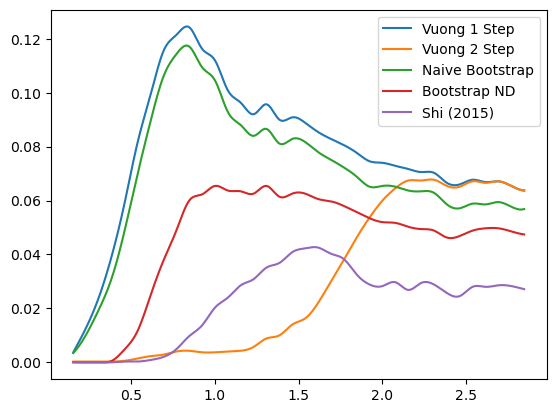

In [8]:
betas = np.linspace(0,3,linspace)
nobs = 100
c1,c2 = calc_c(nobs)
results = []

for beta in betas:
    setup_shi_ex  = lambda yn,xn: setup_shi(yn,xn,num_params=num_params)
    gen_data_ex = lambda : gen_data(nobs=nobs, beta =beta)
    mc_out = vuong_tests_fast.monte_carlo(nsims,gen_data_ex,setup_shi,trials=trials,
                                          skip_boot=skip_boot,skip_shi=skip_shi,refinement_test=refinement_test,c1=c1,c2=c2)
    reg,twostep, refine_test, boot1,boot2,boot3,shi, llr,std, omega = mc_out
    results.append([reg,twostep,refine_test,shi,boot1,boot2,boot3])


name = 'size_nobs%s_c1%s_c2%s_trials%s.png'%(nobs,c1,c2,trials)
create_fig(betas,results,name=name)

# Extra Power Sims

1.8643052460261558 -0.8826447229921152 5.626384253860408
-5.592093310946026 -0.8826447229921152 -1.830014303111773
---
2.9746466452608975 -1.2890779273592634 6.724194166506912
-6.633393083481561 -1.2890779273592634 -2.883845562235546
---
-0.671653784300251 0.3299562759521449 3.139279707154758
-3.1461810087011384 0.3299562759521449 0.6647524827538708
---
-0.895181178589054 0.29224461353017694 2.830042338621128
-2.8532026820891203 0.29224461353017694 0.8720208351210621
---
-1.086884159169367 0.6190734355665211 2.8987809577207098
-2.9355460494965673 0.6190734355665211 1.05011906739351
---
3.6924337422042717 -1.711560106795663 7.666224070673687
-7.636034177775744 -1.711560106795663 -3.6622438493063285
---
0.568515665716895 -0.405562022302893 4.556703036617823
-4.300857208552908 -0.405562022302893 -0.31266983765198
---
-1.1428795336138042 0.6021844813430306 3.0130252701094333
-3.015840474408753 0.6021844813430306 1.1400643293144845
---
-0.9660975987554057 0.3420150852005945 3.18926932938987

-0.989926609450214 0.27538940010840174 3.0025876171444725
-2.941070654057466 0.27538940010840174 1.051443572537221
---
6.442489971641201 -4.624985746754342 10.389060514617608
-10.384988088586788 -4.624985746754342 -6.43841754561038
---
6.596831248606464 -2.8336774250443644 10.577684927569187
-10.517481699670423 -2.8336774250443644 -6.536628020707699
---
0.4667145390795768 -0.6526627240972982 4.282259413988396
-4.370496705610418 -0.6526627240972982 -0.5549518307015993
---
-1.1525237970346225 0.6190421381462711 2.7889544942865845
-2.7264472830722015 0.6190421381462711 1.2150310082490055
---
-0.3423829403758361 0.13408563470845397 3.503456159977093
-3.494702677900152 0.13408563470845397 0.351136422452777
---
-0.38945150408423085 0.13651627658487325 3.5075015443885147
-3.4223505111254617 0.13651627658487325 0.47460253734728397
---
4.559707961112191 -2.3150424352070473 8.367748592677351
-8.462828026453874 -2.3150424352070473 -4.654787394888715
---
0.36377134808704653 -0.458163350769423 4.31

-1.338738708595362 0.5628055173331257 2.6288531258400862
-2.7249296405239956 0.5628055173331257 1.2426621939114524
---
-0.229765189557715 -0.464946795672025 3.6660545383699517
-3.636212157668555 -0.464946795672025 0.25960757025911213
---
-0.5545538667775745 -0.3834201374942602 3.5030528671074226
-3.2822192211749823 -0.3834201374942602 0.775387512710015
---
-0.348284523945844 -0.9514116704417697 3.5388392397546062
-3.3509485225607216 -0.9514116704417697 0.5361752411397283
---
0.49228469501195016 -1.1449060191682505 4.419648115894653
-4.3179593469491975 -1.1449060191682505 -0.3905959260664947
---
3.5901240484892205 -5.15331114805228 7.499383923412217
-7.664672285165061 -5.15331114805228 -3.7554124102420654
---
0.7188705513164415 -1.5432541418099366 4.79232149582008
-4.781667173339069 -1.5432541418099366 -0.7082162288354302
---
-1.2064290277730936 0.6493532899135586 2.7889026699441786
-2.6527895248858053 0.6493532899135586 1.3425421728314675
---
0.3021692384397544 -1.7923227105036525 4.08

0.9039097134722341 -3.219251180979308 4.912440533622906
-5.18437111568021 -3.219251180979308 -1.1758402955295377
---
1.6271307383186158 -3.509252463580314 5.705727715142058
-5.853345730028802 -3.509252463580314 -1.7747487532053594
---
0.07132552811001758 -2.1051204068276195 3.8105497297201985
-3.7972233886853903 -2.1051204068276195 -0.0579991870752094
---
1.570785065951567 -5.867361660362143 5.775005660754633
-6.0020952004840815 -5.867361660362143 -1.797874605681015
---
-1.0352712238257407 -0.5659392737115937 3.1045600890703673
-3.1251504437048547 -0.5659392737115937 1.0146808691912526
---
0.24033890691687143 -2.7535001043647807 4.354596200755962
-4.632188049938234 -2.7535001043647807 -0.5179307560991435
---
-1.4961212326084936 0.5838088880941863 2.6189751539769555
-2.7099887699083802 0.5838088880941863 1.4051076166770684
---
0.8646070157936722 -4.165855877603626 4.897012465998105
-4.998685959133519 -4.165855877603626 -0.9662805089290866
---
0.9884857669478982 -3.4044072570407193 4.996

1.2677044854889883 -7.184832423961658 5.564212198170314
-5.672471836253196 -7.184832423961658 -1.3759641235718694
---
-0.03424727300208764 -4.411098038468792 4.051514743895147
-4.162377970187419 -4.411098038468792 -0.07661595329018406
---
1.5595924157698235 -6.593460138268689 5.499720497684448
-5.397295341485922 -6.593460138268689 -1.4571672595712961
---
0.6159256997018231 -4.089355844745499 4.872837527137443
-4.99973407708232 -4.089355844745499 -0.7428222496467006
---
-0.8217564039562573 -2.309912672802118 3.3595638031018598
-3.4228151929227004 -2.309912672802118 0.7585050141354169
---
-0.6947949600297975 -2.1176666036428333 2.996746889914083
-3.075930008569411 -2.1176666036428333 0.6156118413744698
---
0.36918396694284805 -4.7433970641827 4.362446464336081
-4.195377318754151 -4.7433970641827 -0.20211482136091738
---
0.7860336414429403 -5.61958688538514 4.874863151715157
-4.946957583592807 -5.61958688538514 -0.8581280733205896
---
-0.7046196687350851 -2.1099772155918206 3.331589547469

-1.0547237528556082 -2.2621168012625326 3.0127817203382548
-3.083546651832849 -2.2621168012625326 0.983958821361014
---
0.255414792975351 -8.625186817196699 4.4736213931734135
-4.654755123372912 -8.625186817196699 -0.43654852317484816
---
-1.2119591090037671 -1.578899727766174 2.6871817514465914
-2.8714025690969818 -1.578899727766174 1.027738291353377
---
-1.3603780889207893 -0.7375739825133086 2.6233721395190965
-2.646959500974654 -0.7375739825133086 1.336790727465232
---
0.3476836460077081 -7.0740803952747076 4.436021865963238
-4.651891083146119 -7.0740803952747076 -0.5635528631905893
---
-0.03791197817592002 -6.026069854085671 4.121598333360722
-3.990584687064765 -6.026069854085671 0.16892562447187712
---
-1.078663019635817 -1.6957526437552615 2.703780538629235
-2.658460335480885 -1.6957526437552615 1.1239832227841668
---
-0.15877243403390917 -5.513125360027366 3.8288624776913407
-4.1332377540029865 -5.513125360027366 -0.14560284227773668
---
0.13886981338559998 -7.86479959581193 4.

0.20738408532227176 -9.38690278066532 4.404131509253086
-4.688513842328844 -9.38690278066532 -0.4917664183980285
---
0.21485760843900306 -8.005037033625525 4.117622251466717
-4.2294990377926895 -8.005037033625525 -0.3267343947649761
---
-1.2282172064452033 -3.258485600456537 3.09323657191551
-3.3883258490584662 -3.258485600456537 0.9331279293022471
---
-0.72348141780369 -3.656834629533671 3.1295878391542873
-3.1018750566852127 -3.656834629533671 0.7511942002727642
---
-0.17778448080899656 -8.178868399563576 3.9858545607691065
-4.47874648562511 -8.178868399563576 -0.3151074440470067
---
-1.0591045640850152 -2.5906055228406277 2.790929675041215
-2.68236194807831 -2.5906055228406277 1.1676722910479205
---
-1.159109222904599 -3.293379216659221 2.7773897252603454
-2.9087053060632617 -3.293379216659221 1.0277936421016836
---
0.20116058429162587 -8.966237436619423 4.06536647235071
-4.152200522531575 -8.966237436619423 -0.28799463447249124
---
-1.1194175833790554 -3.4425077512394484 2.81843255

-1.2876909444059488 -3.4944020665731754 2.8157920203194338
-2.968306402972862 -3.4944020665731754 1.1351765617525211
---
-0.7093673589951071 -6.772013851413147 3.203846658022678
-3.2944142154491973 -6.772013851413147 0.618799801568588
---
-0.1569133568840538 -10.245036972338227 4.044574933859848
-4.260800416766834 -10.245036972338227 -0.059312126022932246
---
-0.3529937814134717 -11.3255759029257 3.8931127941304595
-4.027288321386573 -11.3255759029257 0.21881825415735884
---
-0.42063757140629077 -8.494845821973342 3.654012465153625
-3.8648516580595573 -8.494845821973342 0.20979837850035896
---
-0.5283999598012488 -11.391047725710846 3.9353678117961257
-4.302486791829821 -11.391047725710846 0.16128097976755296
---
-0.8020319038287 -5.22032065112495 2.9636492101772416
-3.0564695794534984 -5.22032065112495 0.7092115345524433
---
-0.5740729869364389 -9.65064745564247 3.8753107297022265
-4.194710978374295 -9.65064745564247 0.254672738264371
---
-0.6437570311513809 -10.55785037341518 3.85611

-0.7093511692627998 -10.784405515739017 3.2789009566109675
-3.706778657901796 -10.784405515739017 0.28147346797197137
---
-0.6111318755925337 -12.714146413437524 3.767656140814063
-4.168344834305628 -12.714146413437524 0.21044318210096857
---
-0.7912967131321387 -12.034565591626095 3.9640378329023145
-4.259793062719629 -12.034565591626095 0.495541483314824
---
-0.7348429407298822 -10.641740436310199 3.9728342480076497
-4.139882531714844 -10.641740436310199 0.5677946570226886
---
-0.7496780452330787 -10.45460907804056 3.543737709117661
-3.9933645209513244 -10.45460907804056 0.30005123339941564
---
-1.0134666751369248 -9.44210451964146 3.3367114753143112
-3.594808396656018 -9.44210451964146 0.7553697537952182
---
-0.9883044498255097 -7.832292889074895 3.0790902209043596
-3.0394310698291296 -7.832292889074895 1.0279636009007398
---
-1.057803523594217 -10.004191294320968 3.3790030730615617
-3.7876393472593985 -10.004191294320968 0.6491672493963797
---
-0.7465708409933078 -12.10035545129047

-1.1013035585117752 -13.23477401472911 3.858711981409824
-4.165066351170042 -13.23477401472911 0.7949491887515576
---
-0.8800288690806692 -13.017533599913081 3.4327158451093602
-3.7901300726164844 -13.017533599913081 0.5226146415735454
---
-0.7603740978187494 -12.993602438671337 3.262852971600757
-3.432681421151317 -12.993602438671337 0.590545648268189
---
-1.3523879188089438 -12.29605688145403 3.475612157606151
-4.042597670720076 -12.29605688145403 0.7854024056950191
---
-0.9845409660406402 -10.244374938908111 3.071010123930314
-3.431551528860206 -10.244374938908111 0.6239995611107481
---
-1.2751670154130146 -12.895442642444362 3.502970781388822
-4.13597452835028 -12.895442642444362 0.6421632684515567
---
-1.2053842220715474 -10.456742296221423 3.191513204374358
-3.5901905621667423 -10.456742296221423 0.8067068642791633
---
-1.2228471053771217 -11.199743476565121 3.2535124243603204
-3.440439842106402 -11.199743476565121 1.0359196876310404
---
-0.9175373969984819 -13.995903776699665 3.

-1.6169934893534776 -4.53587386256824 2.521027539230869
-2.723690039827938 -4.53587386256824 1.4143309887564088
---
-1.700870476705123 -9.272415220337875 3.17603022874431
-3.524571366846034 -9.272415220337875 1.3523293386033994
---
-1.315365535620833 -13.754810780773493 3.3684935493031047
-3.612418070797004 -13.754810780773493 1.0714410141269337
---
-1.4943018788930056 -13.854742919290361 3.7417945724524886
-4.076487561919555 -13.854742919290361 1.1596088894259393
---
-1.0301510285252788 -11.51064183724968 3.0832585203072913
-3.0774264445495008 -11.51064183724968 1.0359831042830692
---
-0.9923061159988253 -13.995084705704354 3.0915018565626586
-3.525100968821208 -13.995084705704354 0.5587070037402765
---
-1.5934176396848048 -14.595873156190743 3.3509466051371386
-3.9160570084896142 -14.595873156190743 1.028307236332329
---
-1.3081637700142796 -12.24447243899646 3.3938591293736375
-3.5403374748492227 -12.24447243899646 1.1616854245386947
---
-1.3835603287825653 -11.992423462344764 3.139

-1.3614245163327843 -16.318057347359012 3.3106063096759626
-3.480497402711764 -16.318057347359012 1.191533423296983
---
-1.356929840873326 -16.721638824442273 3.28903661452478
-3.7044955735984506 -16.721638824442273 0.9414708817996554
---
-1.4200061716384758 -12.392786346760944 2.9121673570035798
-3.259166678233832 -12.392786346760944 1.0730068504082235
---
-1.598990289539556 -11.16962002002265 2.856467997626073
-3.3623067776987963 -11.16962002002265 1.093151509466833
---
-1.5437656581015162 -13.314475259116772 2.9949591597640524
-3.4441211944212746 -13.314475259116772 1.0946036234442937
---
-1.2221452405621946 -15.888433296130781 3.451751896089904
-3.726768792364161 -15.888433296130781 0.9471283442879376
---
-1.2696594891917632 -14.525834209550812 3.4303239916665005
-3.501872612773651 -14.525834209550812 1.1981108680846126
---
-1.6722860525598773 -9.547887113801394 2.7116079898161756
-3.071159690758799 -9.547887113801394 1.3127343516172543
---
-1.6360896547980945 -13.741515479147257 3

-1.588900723153781 -14.202015232919772 2.9730271136518813
-3.255767398245637 -14.202015232919772 1.3061604385600254
---
-1.4444703178791185 -17.492498723944607 3.1943943891045907
-3.618713723254385 -17.492498723944607 1.0201509837293246
---
-1.581883459313977 -17.176328659726586 3.2973402252358635
-3.691174616963797 -17.176328659726586 1.1880490675860431
---
-1.4862356076699361 -10.415893985594755 2.7911379658411395
-2.8513591003480854 -10.415893985594755 1.4260144731629902
---
-1.7652933601997312 -19.499424953394893 3.61903201012991
-3.9957641617737414 -19.499424953394893 1.3885612085558998
---
-1.384324197617392 -15.342909223465625 3.3711386030919166
-3.32049278084274 -15.342909223465625 1.4349700198665682
---
-1.89380185180209 -18.98968128992276 3.798572879287813
-4.234220802768361 -18.98968128992276 1.458153928321543
---
-1.5650149756199518 -8.190358011462175 2.5475101697889033
-2.741451906848974 -8.190358011462175 1.3710732385598805
---
-1.6093109103653371 -9.962781416106015 2.555

-2.180495948481934 -17.300774851564245 3.5287745776632473
-3.98216017414127 -17.300774851564245 1.7271103520039113
---
-2.0782133317065417 -18.24949020302817 3.400350621556076
-3.9116896052828527 -18.24949020302817 1.5668743479797649
---
-1.4825434948981322 -13.68119925122727 2.6037293476274144
-2.9671999921533176 -13.68119925122727 1.1190728503722287
---
-1.8282333675832263 -14.536430897905191 3.2615403599174195
-3.44672222499726 -14.536430897905191 1.6430515025033856
---
-2.0997866542856753 -17.24639406424966 3.337320975495264
-3.7729254842106306 -17.24639406424966 1.6641821455703087
---
-1.687679247098746 -17.15098471023554 3.6799794592682336
-3.7162312822523362 -17.15098471023554 1.6514274241146438
---
-1.4412992191559608 -19.57502645410329 3.324015186229244
-3.4641292658994702 -19.57502645410329 1.3011851394857346
---
-1.3927490475159552 -19.991298425804075 3.101788020923583
-3.4057411624256093 -19.991298425804075 1.0887959060139287
---
-2.156786517042678 -20.324467869362252 3.549

-1.8961382978339172 -18.890705791911614 3.36927965513155
-3.7661976973333875 -18.890705791911614 1.4992202556320795
---
-1.9097359933475322 -22.50796321025302 3.646924075526567
-3.822333659688279 -22.50796321025302 1.7343264091858202
---
-2.2097568075464897 -22.11742918926353 3.7670616434044955
-4.16506105605012 -22.11742918926353 1.8117573949008652
---
-2.069634919334585 -18.616486167513404 3.1830573920799314
-3.7297096146147686 -18.616486167513404 1.5229826967997475
---
-2.211857018374794 -19.56829446829559 3.4448219133419813
-3.849380567909195 -19.56829446829559 1.8072983638075804
---
-1.8065720882743532 -19.3589164182708 3.25645307626241
-3.577375600881444 -19.3589164182708 1.4856495636553193
---
-2.085487441840419 -13.218605441808371 3.006092179000169
-3.2700170327048337 -13.218605441808371 1.8215625881357544
---
-1.7250180187832123 -16.467903988245663 3.0926416347917574
-3.3270106243167192 -16.467903988245663 1.4906490292582504
---
-1.8145221156734825 -20.22564077249138 3.2345540

-1.9142696969631194 -20.244669132212074 3.05022481241661
-3.5611311187576633 -20.244669132212074 1.403363390622066
---
-2.0763606324800135 -20.897044801091184 3.252720565092552
-3.6641877689505966 -20.897044801091184 1.6648934286219683
---
-1.9168472928864517 -21.74763366959191 3.5010835802929057
-3.721826708530415 -21.74763366959191 1.6961041646489423
---
-2.3450402451045806 -22.91905435108977 3.6189850957202045
-4.0593603949660615 -22.91905435108977 1.904664945858724
---
-1.953097804632975 -17.165811625580208 3.1673156854528215
-3.362575272605727 -17.165811625580208 1.7578382174800695
---
-2.253523987643328 -19.60574043468996 3.229274072828704
-3.8231739143630974 -19.60574043468996 1.659624146108935
---
-2.011814951038768 -16.252791655008473 2.9142714524984235
-3.2091506304654898 -16.252791655008473 1.7169357730717014
---
-1.921235905651613 -16.200800760225942 2.9662180895811914
-3.1945658134797394 -16.200800760225942 1.6928881817530652
---
-2.0682034778300213 -18.69187930506781 3.15

-2.074223670812605 -23.377831861121333 3.3381654888947323
-3.604921848680996 -23.377831861121333 1.8074673110263408
---
-2.482962367238534 -25.95129971710009 3.3566735962058503
-4.162373760429144 -25.95129971710009 1.6772622030152393
---
-2.4051448705103176 -20.37773553938651 3.2796654657944138
-3.737039294871463 -20.37773553938651 1.9477710414332683
---
-2.105902418999014 -18.91615630268095 2.895513257400517
-3.465967441140432 -18.91615630268095 1.535448235259099
---
-2.1148213187832745 -17.0724772805343 2.7792085727762887
-3.3629979247504345 -17.0724772805343 1.531031966809129
---
-2.1477478321381316 -24.22863906034119 3.3703916652828037
-3.8428215982275473 -24.22863906034119 1.675317899193388
---
-2.27328765100964 -19.348886489117515 3.093435008810619
-3.5465650719413624 -19.348886489117515 1.820157587878896
---
-1.8306413613696773 -20.26933574356878 3.0374130205025667
-3.3436802698187273 -20.26933574356878 1.5243741120535164
---
-2.240268017473215 -18.721201537325005 3.351904901958

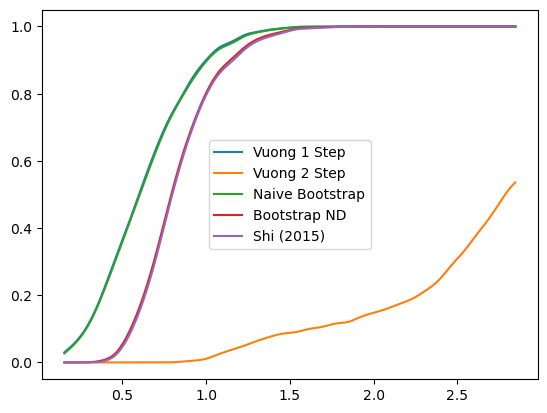

In [9]:
betas = np.linspace(0,3,linspace)
nobs = 250
c1,c2 = calc_c(nobs)
results = []


for beta in betas:
    setup_shi_ex  = lambda yn,xn: setup_shi(yn,xn)
    gen_data_ex = lambda : gen_data3(nobs=nobs, beta =beta)
    mc_out = vuong_tests_fast.monte_carlo(nsims,gen_data_ex,setup_shi_ex,trials=trials,
                                          skip_boot=skip_boot,skip_shi=skip_shi,refinement_test=refinement_test,c1=c1,c2=c2)
    reg,twostep, refine_test, boot1,boot2,boot3,shi, llr,std, omega = mc_out
    results.append([reg,twostep,refine_test,shi,boot1,boot2,boot3])

name = 'power_nobs%s_c1%s_c2%s_trials%s.png'%(nobs,c1,c2,trials)
create_fig(betas,results,name=name)

In [ ]:

betas = np.linspace(0,3,linspace)
nobs = 500
c1,c2 = calc_c(nobs)
results = []


for beta in betas:
    setup_shi_ex  = lambda yn,xn: setup_shi(yn,xn)
    gen_data_ex = lambda : gen_data3(nobs=nobs, beta =beta)
    mc_out = vuong_tests_fast.monte_carlo(nsims,gen_data_ex,setup_shi_ex,trials=trials,
                                          skip_boot=skip_boot,skip_shi=skip_shi,refinement_test=refinement_test,c1=c1,c2=c2)
    reg,twostep, refine_test, boot1,boot2,boot3,shi, llr,std, omega = mc_out
    results.append([reg,twostep,refine_test,shi,boot1,boot2,boot3])

name = 'power_nobs%s_c1%s_c2%s_trials%s.png'%(nobs,c1,c2,trials)
create_fig(betas,results,name=name)

-0.20419449976656698 0.3889737006421091 3.7471682034808813
-3.667999715267719 0.3889737006421091 0.2833629879797296
---
30.920528463271957 -6.574006982793267 34.933345808130284
-35.204776250437305 -6.574006982793267 -31.19195890557897
---
2.171090156351546 -0.6917778203389022 6.1517396903422705
-6.1036664483712375 -0.6917778203389022 -2.123016914380513
---
418.9436420189788 -76.405397277284 427.9758130128433
-428.4657290852295 -76.405397277284 -419.433558091365
---
0.1193804687589003 0.02856216268203354 3.871097270721232
-3.992931220047216 0.02856216268203354 -0.24121441808488436
---
13.980072764554238 -2.712229814131948 17.700178447167303
-17.585403814318788 -2.712229814131948 -13.865298131705721
---
-0.4820635975003203 0.43665500610348035 3.509479597609125
-3.443849340036755 0.43665500610348035 0.5476938550726906
---
48.35900706054004 -9.72541258647966 52.29019509044729
-52.297174895636104 -9.72541258647966 -48.36598686572885
---
7.52543181501536 -1.7847860789426195 11.35536808396505

9.015725756412934 -3.237506323087032 13.00832323588745
-13.111755463720876 -3.237506323087032 -9.119157984246359
---
2.645382047926385 -1.1087303154701564 6.55164889966341
-6.627203910192931 -1.1087303154701564 -2.720937058455907
---
3.4542611122313347 -1.1593681546177914 7.348033553861702
-7.399010217212235 -1.1593681546177914 -3.505237775581868
---
2.824075970338962 -1.2962721695927772 6.968423913432988
-7.13826751059822 -1.2962721695927772 -2.9939195675041943
---
5.259954533197364 -2.176924900605729 9.226517884658849
-9.222103143896089 -2.176924900605729 -5.255539792434604
---
2.8730545174266924 -1.6023633561135326 6.667335019819817
-6.766484118707589 -1.6023633561135326 -2.972203616314464
---
1.2088006686903157 -0.5428134533012029 5.0249725893595
-5.0264722790921095 -0.5428134533012029 -1.2103003584229257
---
0.5493491140654222 0.07555005866209352 4.393725937019046
-4.489640888600076 0.07555005866209352 -0.6452640656464521
---
11.989205750756978 -4.155432852356637 15.95786694367855

2.914453338858283 -3.339866876542558 6.886120886888663
-7.1044981029407595 -3.339866876542558 -3.1328305549103797
---
2.7526839914664705 -3.233408318558192 6.815212433407636
-7.00130719916101 -3.233408318558192 -2.9387787572198447
---
-0.43624531405747974 -0.4397295791766796 3.36685257819597
-3.235397452844487 -0.4397295791766796 0.5677004394089626
---
-1.1681429660733973 0.7542137820008874 2.8056739964199875
-2.7461131861696844 0.7542137820008874 1.227703776323701
---
2.355678749779843 -3.9235370560685796 6.312204255909694
-6.421647771403183 -3.9235370560685796 -2.4651222652733327
---
-0.5980426798734289 -0.5767759957345856 3.480482025906383
-3.6488015777407683 -0.5767759957345856 0.4297231280390436
---
1.8177998671343203 -2.6505931637897637 5.5704896914494055
-5.590500993103294 -2.6505931637897637 -1.8378111687882095
---
-0.07964409484219707 -0.6982939113605103 3.7888967140748044
-3.6930593654846016 -0.6982939113605103 0.17548144343240002
---
2.9682626723188164 -3.4806607108691794 6.

2.3023145713392488 -5.911551700528526 6.28850527517393
-6.499608891816699 -5.911551700528526 -2.5134181879820185
---
-0.21488005700915322 -1.8584410156560625 3.7991061966502877
-3.6797370535723104 -1.8584410156560625 0.3342492000871308
---
0.334218329789788 -3.1020912002376306 4.446574916514986
-4.610940200750919 -3.1020912002376306 -0.49858361402572055
---
-0.6391712285223694 -1.1241454857720072 3.2611698328738274
-3.221426969598961 -1.1241454857720072 0.6789140917972355
---
2.686081760976973 -6.4192787030610345 6.787986332278181
-6.674679116837516 -6.4192787030610345 -2.5727745455363076
---
0.32791910633507404 -3.053054281556315 4.085413182897658
-4.347272697385903 -3.053054281556315 -0.5897786208233191
---
2.251178683776488 -5.510974211962301 6.203639130860248
-6.330385222354306 -5.510974211962301 -2.3779247752705466
---
3.7289708647127937 -6.72013035870308 7.74439290327853
-7.8344868916276 -6.72013035870308 -3.819064853061865
---
-0.22023611826374126 -2.0828815260014304 3.597257474

0.872428420382692 -4.0545109559402785 4.798077550816293
-4.691294236067693 -4.0545109559402785 -0.765645105634092
---
0.187087660397388 -4.1198797830931815 4.051085081470044
-4.091997668794978 -4.1198797830931815 -0.22800024772232255
---
1.6456028217669576 -7.601847029237625 5.807384220303427
-5.897011596827006 -7.601847029237625 -1.7352301982905365
---
1.173857075159493 -6.072289861985371 5.257077731554773
-5.195139182922305 -6.072289861985371 -1.111918526527025
---
1.2628160519366407 -7.195444817980003 5.373875342364049
-5.2289800612391995 -7.195444817980003 -1.1179207708117918
---
0.5101119180806438 -5.9922528176264 4.424100643381357
-4.403275865500597 -5.9922528176264 -0.48928714019988356
---
1.7010361898645359 -10.260704881179551 5.90554864766608
-6.242134408516175 -10.260704881179551 -2.03762195071463
---
-0.23982534375534809 -4.8546751956622405 3.8421640661319816
-3.776063630432991 -4.8546751956622405 0.30592577945433863
---
0.8251365072017984 -7.38450197538992 5.056682061535159

0.315130426616263 -8.95523185177075 4.017166533641794
-4.054933879150927 -8.95523185177075 -0.3528977721253958
---
0.2472334213333893 -9.504244494284006 4.40399032414976
-4.4579598724693 -9.504244494284006 -0.3012029696529291
---
1.2917463591857266 -9.227670086977945 5.3206555646110365
-5.392272428293641 -9.227670086977945 -1.3633632228683306
---
-0.8570356766327728 -4.764167261966249 3.101481996763804
-3.4102292210539358 -4.764167261966249 0.548288452342641
---
-0.09111593326276106 -5.70169258608514 3.8132914123665067
-3.6851521037922135 -5.70169258608514 0.21925524183705428
---
0.5742507442370999 -10.178294865417696 4.585886776598182
-4.763783399591523 -10.178294865417696 -0.7521473672304402
---
0.7819771424766168 -9.23696302932765 4.559646813456459
-4.550814261835149 -9.23696302932765 -0.7731445908553066
---
-0.5632321300743178 -3.3237719525145737 3.3494260510855045
-3.199049446515886 -3.3237719525145737 0.713608734643936
---
0.5841893682910717 -9.787753753443244 4.7610124635974085


-0.6443573756800952 -5.124478042988141 3.21998065632944
-3.1694532783770715 -5.124478042988141 0.6948847536324638
---
-0.6247842683592786 -6.277480403518706 3.528992054893204
-3.5967416771747858 -6.277480403518706 0.5570346460776969
---
-0.5951596987654085 -6.986771192158078 3.645733878903211
-3.5782272167618276 -6.986771192158078 0.6626663609067915
---
0.08497163287780345 -10.461011679455227 4.252552294963891
-4.440765353381739 -10.461011679455227 -0.2731846912956513
---
-0.3844517485603677 -10.122769260057554 3.7612853996926217
-3.829794297278366 -10.122769260057554 0.31594285097462316
---
-0.13760318919005016 -12.902566990046761 4.210963335005065
-4.4475726054772 -12.902566990046761 -0.09900608128208449
---
-0.07620907125946692 -13.245352203574361 4.227558334336011
-4.50565282216759 -13.245352203574361 -0.2018854165721128
---
-0.7940731936357142 -6.953523575664969 3.395242078653761
-3.643903128664027 -6.953523575664969 0.5454121436254485
---
0.19542119981971012 -14.15919464685342 4.